In [ ]:
import multiprocessing

# Get the number of available CPU cores
num_workers = multiprocessing.cpu_count()
print(f"Number of available CPU cores: {num_workers}")

Number of available CPU cores: 2


# Introduction

Stock trading strategies are essential for successful
 investment, yet developing a profitable approach is challenging
 due to the complex and dynamic nature of the stock market.
 This paper introduces a Deep Reinforcement Learning (DRL)
 framework for automated stock trading that integrates technical
 and fundamental analyses with a large language model. We
 model the trading environment as a Partially Observable Markov
 Decision Process (POMDP) and propose a hybrid architecture
 that combines Long Short-Term Memory (LSTM) networks
 with Proximal Policy Optimization (PPO) to capture intricate
 temporal patterns in stock market data and make informed
 trading decisions. Our approach incorporates market indicators
 and financial news headlines, analyzed using the FinBERT model,
 to create a comprehensive state representation. Additionally, we
 enhance portfolio stability by incorporating a drawdown penalty
 into the reward function. Evaluations on a dataset of 30 U.S.
 stocks indicate that our model outperforms baseline models
 in terms of cumulative return, maximum earning rate, and
 Sharpe ratio. The results show that our proposed hybrid model
 yields more robust and profitable trading strategies compared to
 conventional methods.

#Setup

To begin, we need to configure the environment necessary for implementing the stock trading model. The following steps outline the initial setup:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
condacolab.check()

In [ ]:
!pip install gymnasium

In [ ]:
pip install stable-baselines3[extra] sb3-contrib


In [ ]:
!conda install -c conda-forge ta-lib

In [ ]:
!pip install vaderSentiment requests

##Loading the model

In [ ]:
# !cp drive/MyDrive/stock_trading_model5.zip stock_trading_model5.zip
# !cp drive/MyDrive/stock_trading_model10.zip stock_trading_model10.zip
# !cp drive/MyDrive/stock_trading_model15.zip stock_trading_model15.zip
# !cp drive/MyDrive/stock_trading_model30.zip stock_trading_model30.zip

#Imports

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import PPO
from scipy.stats import zscore
import talib
import datetime
import torch

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [ ]:
cd drive/MyDrive/DRL/project/extract

/content/drive/MyDrive/DRL/project/extract


In [ ]:
ls

aligned_test_data.pkl          pre_corona_dataset.csv            stock_trading_model_reduced.zip
aligned_test_embeddings.pkl    prev/                             stock_trading_model.zip
aligned_train_data.pkl         raw_analyst_ratings.csv           test_data_with_indicators.pkl
aligned_train_embeddings.pkl   raw_partner_headlines.csv         test_embeddings.csv
analyst_ratings_processed.csv  reduced_test_embeddings.pkl       test_embeddings.pkl
best_stock_trading_model.zip   reduced_train_embeddings.pkl      train_data_with_indicators.pkl
final_stock_trading_model.zip  stock_trading_model2_new.zip      train_embeddings.csv
model/                         stock_trading_model2.zip          train_embeddings.pkl
models/                        stock_trading_model_new.zip
new_article/                   stock_trading_model_reduced1.zip


# News Data Collection and Preprocessing (no need to run any more)

In this section, we will collect and preprocess the news data to be used in our stock trading model. We will extract the data, filter relevant news articles, and apply BERT embeddings to capture the semantic meaning of the news.

## Extracting News Data


First, we extract the news data from a zip file.

In [ ]:
import zipfile
import os

zip_file_path = 'archive.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extract'

extracted_files = os.listdir('extract')
print(extracted_files)


FileNotFoundError: [Errno 2] No such file or directory: 'archive.zip'

In [ ]:
# ls

aligned_test_data.pkl          raw_analyst_ratings.csv           stock_trading_model_reduced.zip
aligned_test_embeddings.pkl    raw_partner_headlines.csv         stock_trading_model.zip
aligned_train_data.pkl         reduced_test_embeddings.pkl       test_embeddings.csv
aligned_train_embeddings.pkl   reduced_train_embeddings.pkl      test_embeddings.pkl
analyst_ratings_processed.csv  stock_trading_model2_new.zip      train_embeddings.csv
best_stock_trading_model.zip   stock_trading_model2.zip          train_embeddings.pkl
final_stock_trading_model.zip  stock_trading_model_new.zip
pre_corona_dataset.csv         stock_trading_model_reduced1.zip


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Loading and Preprocessing News Data

We load the CSV files containing the news data and preprocess the text to standardize the titles and filter relevant news articles.

In [ ]:
import pandas as pd

csv_file_paths = [
    'analyst_ratings_processed.csv',  # Update with actual file paths
    'raw_analyst_ratings.csv',  # Update with actual file paths
    'raw_partner_headlines.csv'   # Update with actual file paths
]

# Load each CSV file into a DataFrame
dfs = [pd.read_csv(file_path) for file_path in csv_file_paths]

# Display the first few rows of each DataFrame
for i, df in enumerate(dfs):
    print(f"DataFrame {i + 1} - First few rows:")
    print(df.head())
    print()


DataFrame 1 - First few rows:
   Unnamed: 0                                              title  \
0         0.0            Stocks That Hit 52-Week Highs On Friday   
1         1.0         Stocks That Hit 52-Week Highs On Wednesday   
2         2.0                      71 Biggest Movers From Friday   
3         3.0       46 Stocks Moving In Friday's Mid-Day Session   
4         4.0  B of A Securities Maintains Neutral on Agilent...   

                        date stock  
0  2020-06-05 10:30:00-04:00     A  
1  2020-06-03 10:45:00-04:00     A  
2  2020-05-26 04:30:00-04:00     A  
3  2020-05-22 12:45:00-04:00     A  
4  2020-05-22 11:38:00-04:00     A  

DataFrame 2 - First few rows:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving

In [ ]:
# dfs[0]

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A
...,...,...,...,...
1400464,1413844.0,Top Narrow Based Indexes For August 29,2011-08-29 10:41:00-04:00,ZX
1400465,1413845.0,Recap: Wednesday's Top Percentage Gainers and ...,2011-06-22 16:44:00-04:00,ZX
1400466,1413846.0,UPDATE: Oppenheimer Color on China Zenix Auto ...,2011-06-21 08:26:00-04:00,ZX
1400467,1413847.0,Oppenheimer Initiates China Zenix At Outperfor...,2011-06-21 05:59:00-04:00,ZX


In [ ]:
# dfs[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A
...,...,...,...,...,...,...
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 00:00:00,ZX
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 00:00:00,ZX
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 00:00:00,ZX
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 00:00:00,ZX


In [ ]:
# dfs[2]

,Unnamed: 0,headline,url,publisher,date,stock
0,2,Agilent Technologies Announces Pricing of $5……...,http://www.gurufocus.com/news/1153187/agilent-...,GuruFocus,2020-06-01 00:00:00,A
1,3,Agilent (A) Gears Up for Q2 Earnings: What's i...,http://www.zacks.com/stock/news/931205/agilent...,Zacks,2020-05-18 00:00:00,A
2,4,J.P. Morgan Asset Management Announces Liquida...,http://www.gurufocus.com/news/1138923/jp-morga...,GuruFocus,2020-05-15 00:00:00,A
3,5,"Pershing Square Capital Management, L.P. Buys ...",http://www.gurufocus.com/news/1138704/pershing...,GuruFocus,2020-05-15 00:00:00,A
4,6,Agilent Awards Trilogy Sciences with a Golden ...,http://www.gurufocus.com/news/1134012/agilent-...,GuruFocus,2020-05-12 00:00:00,A
...,...,...,...,...,...,...
1845554,1849874,Consumer Cyclical Sector Wrap,https://www.benzinga.com/content/12/08/2846030...,webmaster,2012-08-20 00:00:00,ZX
1845555,1849875,Consumer Cyclical Sector Wrap,https://www.benzinga.com/content/12/07/2767124...,webmaster,2012-07-23 00:00:00,ZX
1845556,1849876,Zacks #5 Rank Additions for Monday - Tale of t...,http://www.zacks.com/stock/news/73497/here-are...,Zacks,2012-04-23 00:00:00,ZX
1845557,1849877,4 Stock Strategies From Wall Street: Feb. 9 (U...,http://www.thestreet.com/story/11409053/1/4-st...,TheStreet.Com,2012-02-09 00:00:00,ZX


In [ ]:
import pandas as pd
# Load the CSV files into DataFrames
file_paths = [
    'analyst_ratings_processed.csv',
    'raw_analyst_ratings.csv',
    'raw_partner_headlines.csv'
]

dfs = [pd.read_csv(file_path) for file_path in file_paths]

# Rename 'headline' to 'title' and convert 'title' to lowercase
for df in dfs:
    if 'headline' in df.columns:
        df.rename(columns={'headline': 'title'}, inplace=True)
    if 'title' in df.columns:
        df['title'] = df['title'].str.lower()

In [ ]:
# Function to convert and ensure all dates are included in the 'date' column
def ensure_date_column(df):
    # Convert to datetime and handle mixed time zones
    df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True).dt.date
    # Drop rows where 'date' is NaT
    df.dropna(subset=['date'], inplace=True)
    return df

# Ensure date column is processed correctly
processed_dfs = [ensure_date_column(df) for df in dfs]

# Select only the necessary columns and combine into one DataFrame
combined_df = pd.concat([df[['title', 'date', 'stock']] for df in processed_dfs])
# Sort the combined DataFrame by date
combined_df_sorted = combined_df.sort_values(by='date').reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Display the combined DataFrame
print("Combined DataFrame - First few rows:")
print(combined_df_sorted.head())

# Display full titles for manual checking
print("Full titles for manual checking:")
for _, row in combined_df_sorted.sample(10).iterrows():
    print(f"Title: {row['title']}")
    print(f"Date: {row['date']}")
    print(f"Stock: {row['stock']}")
    print()

Combined DataFrame - First few rows:
                                               title        date stock
0  montpelier re holdings ltd. (mrh): new analyst...  1969-12-31   MRH
1                       how treasuries and etfs work  2009-02-14   NAV
2      update on the luxury sector: 2nd quarter 2009  2009-04-27    FT
3      update on the luxury sector: 2nd quarter 2009  2009-04-27     Y
4                             going against the herd  2009-04-29     A
Full titles for manual checking:
Title: bulletproof investing performance update: week 92
Date: 2019-08-29
Stock: NXST

Title: under armour is a winner - cramer's lightning round (6/20/18)
Date: 2018-06-21
Stock: FEYE

Title: from earlier: generac boosts forecast; guides fy12 eps $2.65-2.70 vs $2.22 est; guides q3 sales $295-300m vs $235.9m est; guides q3 eps $0.72-0.77 vs $0.46 est
Date: 2012-10-01
Stock: GNRC

Title: brookfield property offers for rest of brookfield canada office properties
Date: 2017-01-23
Stock: BOXC

Title: ax

In [ ]:
# Drop the 'stock' column as it is not needed
combined_df_sorted.drop(columns=['stock'], inplace=True)

# Remove duplicate rows based on the 'date' and 'title' columns
combined_df_sorted.drop_duplicates(subset=['date', 'title'], inplace=True)

# Display the cleaned and sorted DataFrame
print("Cleaned and Sorted DataFrame - First few rows:")
print(combined_df_sorted.head())

# Display full titles for manual checking
print("\n\n Full titles for manual checking:")
for _, row in combined_df_sorted.sample(10).iterrows():
    print(f"Title: {row['title']}")
    print(f"Date: {row['date']}")
    print()

Cleaned and Sorted DataFrame - First few rows:
                                               title        date
0  montpelier re holdings ltd. (mrh): new analyst...  1969-12-31
1                       how treasuries and etfs work  2009-02-14
2      update on the luxury sector: 2nd quarter 2009  2009-04-27
4                             going against the herd  2009-04-29
5  charles sizemore radio interview saturday morning  2009-05-22


 Full titles for manual checking:
Title: guggenheim securities downgrades tesco corporation to neutral, lowers pt to $16.00
Date: 2014-12-01

Title: good news watch: don't count qualcomm, inc. (qcom) out
Date: 2013-04-03

Title: capital bancorp late friday reported q4 eps $0.25 beat $0.23 est.
Date: 2019-02-11

Title: clearone's (clro) ceo zee hakimoglu on q1 2015 results - earnings call transcript
Date: 2015-05-03

Title: geospace technologies misses by $0.42, misses on revenue
Date: 2017-02-08

Title: rowan -4% following mixed q4 results
Date: 2018-02-2

In [ ]:
combined_df_sorted

,title,date
0,montpelier re holdings ltd. (mrh): new analyst...,1969-12-31
1,how treasuries and etfs work,2009-02-14
2,update on the luxury sector: 2nd quarter 2009,2009-04-27
4,going against the herd,2009-04-29
5,charles sizemore radio interview saturday morning,2009-05-22
...,...,...
3299182,wells fargo upgrades westlake chemical to over...,2020-06-11
3299195,"financials, energy among worst-hit sectors in ...",2020-06-11
3299196,an etf play on laggard stocks,2020-06-11
3299199,sam's club earlier announced it has launched c...,2020-06-11


In [ ]:
# Function to determine the start date with steady news data
def find_steady_start_date(df, threshold=5):
    # Count the number of news articles per day
    daily_counts = df['date'].value_counts().sort_index()

    # Find the date from which the count is consistently above the threshold
    steady_dates = daily_counts[daily_counts >= threshold]
    if not steady_dates.empty:
        start_date = steady_dates.index[0]
        return start_date
    else:
        return None

start_date = find_steady_start_date(combined_df_sorted, threshold=5)

print("Appropriate start date:", start_date)

Appropriate start date: 2009-07-27


In [ ]:
mkdir new_article

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
cd new_article

/content/drive/.shortcut-targets-by-id/1AClMngfY2sCeLw_kmHzp_xMdoHYklRsc/project/extract/new_article


In [ ]:
!pip install vaderSentiment


In [ ]:
!pip install numpy==1.21.0
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 64.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.21.0-cp310-cp310-linux_x86_64.whl size=5261522 sha256=87df8959ea0389c31256328ecdd8b9de3f27e984a80250c6312c80f0ff893484
  Stored in directory: /root/.cache/pip/wheels/05/61/d1/ccc2cd557b39e127ad98a392d9558f3c5dda28764b7f54b2f5
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.9.1 requires numpy>=1.23, but you have numpy 1.21.0 which is incompatible.
opencv-python 4.10.0.84 requires numpy>=1.21.2; python_version >= "3.10", b

In [ ]:
# Filter the DataFrame to keep only data from the start date onwards
filtered_df = combined_df_sorted[combined_df_sorted['date'] >= start_date]

# Display the filtered DataFrame
print("Filtered DataFrame - First few rows:")
print(filtered_df.head())

Filtered DataFrame - First few rows:
                                                title        date
77  pg&e contracts with sempra generation for more...  2009-07-27
78  wall street news alert:  stocks this morning: ...  2009-07-27
79  con-way inc. sends a record 89 drivers to nati...  2009-07-27
80        olin announces second quarter 2009 earnings  2009-07-27
81  paramount gold and silver corp. provides updat...  2009-07-27


In [ ]:
filtered_df.to_csv('filtered_news_data.csv', index=False)

# Bert

In [ ]:
cd new_article/

/content/drive/.shortcut-targets-by-id/1AClMngfY2sCeLw_kmHzp_xMdoHYklRsc/project/extract/new_article


In [ ]:
ls

filtered_news_data.csv  news_data_with_finbert_embeddings.pkl  yetanother/


In [ ]:
# Load the pre-processed news data
news_data = pd.read_csv('filtered_news_data.csv')

# Convert date column to datetime
news_data['date'] = pd.to_datetime(news_data['date'])


In [ ]:
news_data

,title,date
0,pg&e contracts with sempra generation for more...,2009-07-27
1,wall street news alert: stocks this morning: ...,2009-07-27
2,con-way inc. sends a record 89 drivers to nati...,2009-07-27
3,olin announces second quarter 2009 earnings,2009-07-27
4,paramount gold and silver corp. provides updat...,2009-07-27
...,...,...
1751984,wells fargo upgrades westlake chemical to over...,2020-06-11
1751985,"financials, energy among worst-hit sectors in ...",2020-06-11
1751986,an etf play on laggard stocks,2020-06-11
1751987,sam's club earlier announced it has launched c...,2020-06-11


## Applying BERT Embeddings

We use BERT to obtain embeddings for the news titles, capturing the semantic meaning of the text.

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
import psutil
import dask.dataframe as dd

In [ ]:
# Load pre-trained FinBERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertModel.from_pretrained('yiyanghkust/finbert-tone')

# Choose the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


cuda


In [ ]:
# Custom Dataset class for batching
class NewsDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        return {key: val.squeeze(0) for key, val in inputs.items()}

# Function to compute BERT embeddings in batches with logging and memory check
def get_bert_embeddings_batch(texts, tokenizer, model, device, batch_size=2048, max_length=128, log_interval=10):
    dataset = NewsDataset(texts, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_embeddings = []
    model.to(device)
    total_batches = len(dataloader)
    for batch_idx, batch in enumerate(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        all_embeddings.append(embeddings.cpu())

        if (batch_idx + 1) % log_interval == 0:
            print(f"Processed {batch_idx + 1}/{total_batches} batches")
            print(f"Memory usage: {psutil.virtual_memory().percent}%")

    all_embeddings = torch.cat(all_embeddings).numpy()
    return all_embeddings

# Apply FinBERT embeddings to each headline in batches
texts = news_data['title'].tolist()
embeddings = get_bert_embeddings_batch(texts, tokenizer, model, device, batch_size=2048, max_length=128)

# Combine embeddings into a DataFrame and concatenate with the original DataFrame
embeddings_df = pd.DataFrame(embeddings, columns=[f'embedding_{i}' for i in range(embeddings.shape[1])])
news_data = pd.concat([news_data.reset_index(drop=True), embeddings_df.reset_index(drop=True)], axis=1)

# Save the news data with embeddings for later use
news_data.to_pickle('news_data_with_finbert_embeddings.pkl')



Processed 10/856 batches
Memory usage: 6.8%
Processed 20/856 batches
Memory usage: 6.9%
Processed 30/856 batches
Memory usage: 6.8%
Processed 40/856 batches
Memory usage: 5.9%
Processed 50/856 batches
Memory usage: 5.9%
Processed 60/856 batches
Memory usage: 6.1%
Processed 70/856 batches
Memory usage: 6.2%
Processed 80/856 batches
Memory usage: 6.3%
Processed 90/856 batches
Memory usage: 6.4%
Processed 100/856 batches
Memory usage: 6.5%
Processed 110/856 batches
Memory usage: 6.6%
Processed 120/856 batches
Memory usage: 6.8%
Processed 130/856 batches
Memory usage: 6.9%
Processed 140/856 batches
Memory usage: 7.0%
Processed 150/856 batches
Memory usage: 7.1%
Processed 160/856 batches
Memory usage: 7.3%
Processed 170/856 batches
Memory usage: 7.4%
Processed 180/856 batches
Memory usage: 7.5%
Processed 190/856 batches
Memory usage: 7.6%
Processed 200/856 batches
Memory usage: 7.7%
Processed 210/856 batches
Memory usage: 7.9%
Processed 220/856 batches
Memory usage: 8.0%
Processed 230/856 b

In [ ]:
ls

filtered_news_data.csv  news_data_with_finbert_embeddings.pkl  yetanother/


In [ ]:
# Load the pre-processed news data from the pickle file
news_data  = pd.read_pickle('news_data_with_finbert_embeddings.pkl')

In [ ]:
# Display the updated DataFrame
print(news_data.head())

                                               title       date  embedding_0  \
0  pg&e contracts with sempra generation for more... 2009-07-27     0.491175   
1  wall street news alert:  stocks this morning: ... 2009-07-27    -0.024769   
2  con-way inc. sends a record 89 drivers to nati... 2009-07-27     0.210233   
3        olin announces second quarter 2009 earnings 2009-07-27    -0.690394   
4  paramount gold and silver corp. provides updat... 2009-07-27     0.498933   

   embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0     0.096761     0.065318     0.123933     0.709237    -0.328635   
1    -1.096686     0.266670     0.187258     0.569522    -1.011142   
2    -0.560645    -1.030936     0.363811     0.998744    -0.890504   
3    -1.238946    -0.682186    -1.006304     1.131564    -0.337946   
4    -0.202252    -0.831459    -0.366995     0.968075    -1.109942   

   embedding_6  embedding_7  ...  embedding_758  embedding_759  embedding_760  \
0     0.985247   

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
news_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,date,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,pg&e contracts with sempra generation for more...,2009-07-27,0.491175,0.096761,0.065318,0.123933,0.709237,-0.328635,0.985247,0.697016,...,0.414806,-0.393555,-0.268612,0.756419,0.044287,-1.072915,-0.197082,0.297615,0.052536,0.480949
1,wall street news alert: stocks this morning: ...,2009-07-27,-0.024769,-1.096686,0.266670,0.187258,0.569522,-1.011142,-0.105828,0.023734,...,-0.132941,-0.120066,-0.422062,0.135723,0.225281,-0.058247,-0.522535,0.020749,-0.377718,1.154018
2,con-way inc. sends a record 89 drivers to nati...,2009-07-27,0.210233,-0.560645,-1.030936,0.363811,0.998744,-0.890504,0.047659,-0.029525,...,0.223274,-0.210228,0.005377,-0.031494,0.393228,0.087988,0.184784,-0.195332,-0.138465,0.584097
3,olin announces second quarter 2009 earnings,2009-07-27,-0.690394,-1.238946,-0.682186,-1.006304,1.131564,-0.337946,-0.776125,0.574196,...,0.251600,0.348602,0.847306,0.022502,1.334403,-0.460116,0.947327,0.398219,-0.047983,0.164640
4,paramount gold and silver corp. provides updat...,2009-07-27,0.498933,-0.202252,-0.831459,-0.366995,0.968075,-1.109942,0.125720,-0.365210,...,-0.009598,-0.808776,0.051126,0.011213,0.549859,-0.012268,0.406547,0.116938,0.136901,0.170659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751984,wells fargo upgrades westlake chemical to over...,2020-06-11,0.211258,-0.508530,0.124621,-0.025147,1.088705,-0.049697,-0.449533,-0.111232,...,0.422525,0.723985,-0.927647,0.362117,0.143535,-0.102966,1.026210,0.450549,-0.441842,0.143785
1751985,"financials, energy among worst-hit sectors in ...",2020-06-11,0.159251,0.220575,0.037295,1.002974,-0.180502,0.283981,-0.877592,-0.123289,...,0.625695,0.624232,0.955981,-0.678343,0.338824,0.318082,-0.458469,-0.321598,-0.427846,0.477943
1751986,an etf play on laggard stocks,2020-06-11,-0.839026,-0.808230,-0.212145,0.417930,0.833936,-0.272981,-0.180339,0.394329,...,0.299925,-0.134421,-0.245612,0.190362,-0.000670,1.087796,-0.137903,0.822453,-0.426504,-0.292793
1751987,sam's club earlier announced it has launched c...,2020-06-11,-0.389984,-0.948479,-1.384802,0.774570,0.620252,-1.058451,-0.109521,-0.143536,...,0.361543,-0.527286,0.231316,0.250584,-0.362542,-0.599883,0.246089,0.330296,0.357028,0.140384


In [ ]:
# Load the processed data with embeddings using Pandas
news_data = pd.read_pickle('news_data_with_finbert_embeddings.pkl')

# Identify the embedding columns
embedding_columns = [col for col in news_data.columns if col.startswith('embedding_')]

# Function to convert embedding columns to a list and then to a tensor for each row
def embeddings_to_tensor(row, embedding_columns):
    embedding_list = row[embedding_columns].values.tolist()
    return torch.tensor(embedding_list)

# Process the DataFrame in chunks
chunksize = 250000  # Adjust the chunk size based on your memory constraints
num_chunks = len(news_data) // chunksize + 1

# Initialize an empty list to store processed chunks
processed_chunks = []

for i in range(num_chunks):
    start_index = i * chunksize
    end_index = (i + 1) * chunksize
    chunk = news_data.iloc[start_index:end_index].copy()

    chunk['embedding'] = chunk.apply(lambda row: embeddings_to_tensor(row, embedding_columns), axis=1)
    chunk = chunk.drop(columns=embedding_columns)

    processed_chunks.append(chunk)
    print(f"Processed chunk {i + 1}/{num_chunks}")

# Concatenate all processed chunks
news_data_final = pd.concat(processed_chunks, ignore_index=True)

# Save the final processed data
news_data_final.to_pickle('news_data_with_tensor_embeddings_all.pkl')

Processed chunk 1/8
Processed chunk 2/8
Processed chunk 3/8
Processed chunk 4/8
Processed chunk 5/8
Processed chunk 6/8
Processed chunk 7/8
Processed chunk 8/8


In [ ]:
news_data = pd.read_pickle('news_data_with_tensor_embeddings_all.pkl')

In [ ]:
news_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,date,embedding
0,pg&e contracts with sempra generation for more...,2009-07-27,"[tensor(0.4912), tensor(0.0968), tensor(0.0653..."
1,wall street news alert: stocks this morning: ...,2009-07-27,"[tensor(-0.0248), tensor(-1.0967), tensor(0.26..."
2,con-way inc. sends a record 89 drivers to nati...,2009-07-27,"[tensor(0.2102), tensor(-0.5606), tensor(-1.03..."
3,olin announces second quarter 2009 earnings,2009-07-27,"[tensor(-0.6904), tensor(-1.2389), tensor(-0.6..."
4,paramount gold and silver corp. provides updat...,2009-07-27,"[tensor(0.4989), tensor(-0.2023), tensor(-0.83..."
...,...,...,...
1751984,wells fargo upgrades westlake chemical to over...,2020-06-11,"[tensor(0.2113), tensor(-0.5085), tensor(0.124..."
1751985,"financials, energy among worst-hit sectors in ...",2020-06-11,"[tensor(0.1593), tensor(0.2206), tensor(0.0373..."
1751986,an etf play on laggard stocks,2020-06-11,"[tensor(-0.8390), tensor(-0.8082), tensor(-0.2..."
1751987,sam's club earlier announced it has launched c...,2020-06-11,"[tensor(-0.3900), tensor(-0.9485), tensor(-1.3..."


In [ ]:
# Sample data to check embeddings
sample_data = news_data.sample(1)
for index, row in sample_data.iterrows():
    print(f"Title: {row['title']}")
    print(f"Embedding Shape: {len(row['embedding'])}")
    print(f"Embedding: {row['embedding']}\n")

Title: option alert: vmw oct16 62.5 calls sweep: 1288 @  ask  $5.40: 1288 traded vs 2041 oi:  earnings 7/18 after close  $62.17 ref
Embedding Shape: 768
Embedding: tensor([ 2.8588e-01, -9.0080e-01, -4.8000e-01,  7.7706e-01,  2.5183e-01,
        -1.2057e+00,  8.5610e-02, -3.1078e-01,  6.5432e-02,  9.0632e-01,
         3.9437e-01, -5.8214e-01,  7.4969e-01, -6.2187e-01,  4.0848e-02,
         6.2080e-01, -5.9173e-01,  4.5714e-01, -3.4964e-02,  6.7658e-01,
         4.8737e-01, -3.1501e-01,  4.2125e-01,  1.2420e-01,  5.7016e-02,
         3.8094e-01, -1.2488e+00,  1.0758e+00,  5.0596e-01, -5.5587e-01,
        -2.0709e-01,  6.1703e-01,  1.0445e+00, -6.9112e-01, -4.4868e-01,
         1.2711e-01, -7.2103e-01, -4.6438e-01,  9.4246e-02, -1.7427e-01,
        -6.2008e-01, -9.1127e-01, -1.9765e-03, -6.8883e-02, -4.0249e-01,
        -5.0982e-02, -4.0294e-02, -1.9356e-01,  6.1131e-01,  1.8326e-01,
         5.0374e-01, -1.1351e+00, -2.7211e-02,  9.2917e-01, -1.1512e-01,
         4.3935e-01, -7.5569e-01,

In [ ]:
# Convert the embedding column from list to tensor
news_data['embedding'] = news_data['embedding'].apply(lambda x: torch.tensor(x))

<ipython-input-21-3a2e8be21f2b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  news_data['embedding'] = news_data['embedding'].apply(lambda x: torch.tensor(x))


In [ ]:
news_data

,title,date,embedding
0,pg&e contracts with sempra generation for more...,2009-07-27,"[tensor(0.4912), tensor(0.0968), tensor(0.0653..."
1,wall street news alert: stocks this morning: ...,2009-07-27,"[tensor(-0.0248), tensor(-1.0967), tensor(0.26..."
2,con-way inc. sends a record 89 drivers to nati...,2009-07-27,"[tensor(0.2102), tensor(-0.5606), tensor(-1.03..."
3,olin announces second quarter 2009 earnings,2009-07-27,"[tensor(-0.6904), tensor(-1.2389), tensor(-0.6..."
4,paramount gold and silver corp. provides updat...,2009-07-27,"[tensor(0.4989), tensor(-0.2023), tensor(-0.83..."
...,...,...,...
1751984,wells fargo upgrades westlake chemical to over...,2020-06-11,"[tensor(0.2113), tensor(-0.5085), tensor(0.124..."
1751985,"financials, energy among worst-hit sectors in ...",2020-06-11,"[tensor(0.1593), tensor(0.2206), tensor(0.0373..."
1751986,an etf play on laggard stocks,2020-06-11,"[tensor(-0.8390), tensor(-0.8082), tensor(-0.2..."
1751987,sam's club earlier announced it has launched c...,2020-06-11,"[tensor(-0.3900), tensor(-0.9485), tensor(-1.3..."


In [ ]:
# Aggregate daily embeddings by averaging them
def aggregate_daily_embeddings(df):
    daily_embeddings = df.groupby('date')['embedding'].apply(lambda x: torch.mean(torch.stack(list(x)), dim=0))
    return daily_embeddings

daily_embeddings = aggregate_daily_embeddings(news_data)


In [ ]:
daily_embeddings

date
2009-07-27    [tensor(-0.0047), tensor(-0.5514), tensor(-0.4...
2009-07-28    [tensor(-0.5202), tensor(-1.0556), tensor(-0.6...
2009-07-30    [tensor(-0.2491), tensor(-0.1559), tensor(-0.3...
2009-08-01    [tensor(0.1238), tensor(0.8047), tensor(-0.932...
2009-08-03    [tensor(-0.4197), tensor(0.1578), tensor(-0.65...
                                    ...                        
2020-06-07    [tensor(0.0332), tensor(-0.5830), tensor(-0.39...
2020-06-08    [tensor(0.0120), tensor(-0.4624), tensor(-0.15...
2020-06-09    [tensor(0.0302), tensor(-0.4132), tensor(-0.17...
2020-06-10    [tensor(0.0139), tensor(-0.4345), tensor(-0.11...
2020-06-11    [tensor(-0.0929), tensor(-0.4762), tensor(-0.1...
Name: embedding, Length: 3957, dtype: object

In [ ]:
# Print the embedding for a sample day
sample_day = daily_embeddings.sample(1)
print(f"Date: {sample_day.index[0]}")
print(f"Aggregated Embedding Shape: {sample_day.values[0].shape}")
print(f"Aggregated Embedding: {sample_day.values[0]}")


Date: 2010-05-09 00:00:00
Aggregated Embedding Shape: torch.Size([768])
Aggregated Embedding: tensor([ 1.1261e-01, -6.4344e-01, -3.8968e-01,  4.0760e-01,  6.9842e-01,
        -3.4466e-01, -1.5672e-01,  1.2734e-01,  7.9419e-02,  3.6510e-01,
         4.7702e-01, -3.5045e-01,  3.4124e-01, -3.6734e-01,  1.9133e-01,
         4.2190e-01,  4.4287e-01,  6.6620e-01,  1.9170e-01,  1.4084e-01,
         9.5163e-02,  1.8416e-01, -1.1597e-01, -5.3146e-02,  2.0916e-01,
         2.7086e-01, -4.3604e-01,  6.9855e-01,  6.2562e-03, -6.8747e-01,
        -1.9604e-01,  3.2554e-01,  8.6811e-01, -1.4282e-02, -2.8015e-01,
         7.8075e-02, -2.4346e-01, -1.4552e-01,  3.8011e-01, -1.6783e-01,
         3.5468e-01, -7.2128e-02,  1.2742e-01, -8.8978e-01,  1.3139e-01,
        -2.5755e-01,  2.1533e-01,  3.1109e-01,  4.7229e-01, -2.3780e-01,
         1.8923e-01, -5.4681e-01,  1.4590e-01,  6.5651e-01,  4.9838e-01,
         3.2425e-01, -8.4087e-02, -1.1790e-01,  1.1994e-01,  2.9395e-01,
         1.2833e-01, -5.0517e-

In [ ]:
daily_embeddings

date
2009-07-27    [tensor(-0.0047), tensor(-0.5514), tensor(-0.4...
2009-07-28    [tensor(-0.5202), tensor(-1.0556), tensor(-0.6...
2009-07-30    [tensor(-0.2491), tensor(-0.1559), tensor(-0.3...
2009-08-01    [tensor(0.1238), tensor(0.8047), tensor(-0.932...
2009-08-03    [tensor(-0.4197), tensor(0.1578), tensor(-0.65...
                                    ...                        
2020-06-07    [tensor(0.0332), tensor(-0.5830), tensor(-0.39...
2020-06-08    [tensor(0.0120), tensor(-0.4624), tensor(-0.15...
2020-06-09    [tensor(0.0302), tensor(-0.4132), tensor(-0.17...
2020-06-10    [tensor(0.0139), tensor(-0.4345), tensor(-0.11...
2020-06-11    [tensor(-0.0929), tensor(-0.4762), tensor(-0.1...
Name: embedding, Length: 3957, dtype: object

In [ ]:
# Ensure daily_embeddings is a DataFrame
daily_embeddings_df = pd.DataFrame(daily_embeddings)

In [ ]:
# Reset the index to ensure 'date' is a column
daily_embeddings_df.reset_index(inplace=True)

In [ ]:
daily_embeddings_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,embedding
0,2009-07-27,"[tensor(-0.0047), tensor(-0.5514), tensor(-0.4..."
1,2009-07-28,"[tensor(-0.5202), tensor(-1.0556), tensor(-0.6..."
2,2009-07-30,"[tensor(-0.2491), tensor(-0.1559), tensor(-0.3..."
3,2009-08-01,"[tensor(0.1238), tensor(0.8047), tensor(-0.932..."
4,2009-08-03,"[tensor(-0.4197), tensor(0.1578), tensor(-0.65..."
...,...,...
3952,2020-06-07,"[tensor(0.0332), tensor(-0.5830), tensor(-0.39..."
3953,2020-06-08,"[tensor(0.0120), tensor(-0.4624), tensor(-0.15..."
3954,2020-06-09,"[tensor(0.0302), tensor(-0.4132), tensor(-0.17..."
3955,2020-06-10,"[tensor(0.0139), tensor(-0.4345), tensor(-0.11..."


In [ ]:
# Save the daily embeddings
daily_embeddings_df.to_csv('daily_embeddings_df.csv', index=True)

In [ ]:
with open('daily_embeddings_df.pkl', 'wb') as f:
    pickle.dump(daily_embeddings_df, f)

In [ ]:
ls

daily_embeddings.csv     filtered_news_data.csv
daily_embeddings_df.csv  news_data_with_finbert_embeddings.pkl
daily_embeddings_df.pkl  news_data_with_tensor_embeddings_all.pkl
daily_embeddings.pkl     yetanother/


In [ ]:
news_data

,title,date,embedding
0,pg&e contracts with sempra generation for more...,2009-07-27,"[tensor(0.4912), tensor(0.0968), tensor(0.0653..."
1,wall street news alert: stocks this morning: ...,2009-07-27,"[tensor(-0.0248), tensor(-1.0967), tensor(0.26..."
2,con-way inc. sends a record 89 drivers to nati...,2009-07-27,"[tensor(0.2102), tensor(-0.5606), tensor(-1.03..."
3,olin announces second quarter 2009 earnings,2009-07-27,"[tensor(-0.6904), tensor(-1.2389), tensor(-0.6..."
4,paramount gold and silver corp. provides updat...,2009-07-27,"[tensor(0.4989), tensor(-0.2023), tensor(-0.83..."
...,...,...,...
1751984,wells fargo upgrades westlake chemical to over...,2020-06-11,"[tensor(0.2113), tensor(-0.5085), tensor(0.124..."
1751985,"financials, energy among worst-hit sectors in ...",2020-06-11,"[tensor(0.1593), tensor(0.2206), tensor(0.0373..."
1751986,an etf play on laggard stocks,2020-06-11,"[tensor(-0.8390), tensor(-0.8082), tensor(-0.2..."
1751987,sam's club earlier announced it has launched c...,2020-06-11,"[tensor(-0.3900), tensor(-0.9485), tensor(-1.3..."


## Aligning Embeddings with Stock Data

We align the BERT embeddings with stock price dates and prepare them for training and testing.

In [ ]:
news_data = daily_embeddings_df

In [ ]:
news_data

,date,embedding
0,2009-07-27,"[tensor(-0.0047), tensor(-0.5514), tensor(-0.4..."
1,2009-07-28,"[tensor(-0.5202), tensor(-1.0556), tensor(-0.6..."
2,2009-07-30,"[tensor(-0.2491), tensor(-0.1559), tensor(-0.3..."
3,2009-08-01,"[tensor(0.1238), tensor(0.8047), tensor(-0.932..."
4,2009-08-03,"[tensor(-0.4197), tensor(0.1578), tensor(-0.65..."
...,...,...
3952,2020-06-07,"[tensor(0.0332), tensor(-0.5830), tensor(-0.39..."
3953,2020-06-08,"[tensor(0.0120), tensor(-0.4624), tensor(-0.15..."
3954,2020-06-09,"[tensor(0.0302), tensor(-0.4132), tensor(-0.17..."
3955,2020-06-10,"[tensor(0.0139), tensor(-0.4345), tensor(-0.11..."


In [ ]:
import datetime

# Convert the date to datetime and remove the time component
news_data['date'] = pd.to_datetime(news_data['date']).dt.date

start_date = pd.to_datetime('2009-07-27').date()
train_end_date = pd.to_datetime('2015-12-31').date()
test_start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2020-05-08').date()

print(f"Training period: {start_date} to {train_end_date}")
print(f"Testing period: {test_start_date} to {end_date}")

Training period: 2009-07-27 to 2015-12-31
Testing period: 2016-01-01 to 2020-05-08


In [ ]:
# Placeholder for dates with no news: zero vector of the same length as the BERT embeddings
embedding_size = news_data['embedding'].iloc[0].shape[0]
placeholder_embedding = torch.zeros(embedding_size).tolist()  # Convert to list

# Create a new DataFrame aligned with the stock prices dates
all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date
aligned_embeddings = pd.DataFrame(index=all_dates, columns=['embedding'])

# Populate the DataFrame with available embeddings
for index, row in news_data.iterrows():
    aligned_embeddings.at[row['date'], 'embedding'] = row['embedding'].tolist()  # Convert to list

# Fill missing dates with placeholder embeddings
aligned_embeddings['embedding'] = aligned_embeddings['embedding'].apply(lambda x: x if isinstance(x, list) else placeholder_embedding)

# Split the aligned embeddings into training and testing sets
train_embeddings = aligned_embeddings.loc[start_date:train_end_date]
test_embeddings = aligned_embeddings.loc[test_start_date:end_date]

In [ ]:
# Save train embeddings
train_embeddings.to_csv('train_embeddings.csv', index=True)

# Save test embeddings
test_embeddings.to_csv('test_embeddings.csv', index=True)


In [ ]:
# Save train embeddings
with open('train_embeddings.pkl', 'wb') as f:
    pickle.dump(train_embeddings, f)

# Save test embeddings
with open('test_embeddings.pkl', 'wb') as f:
    pickle.dump(test_embeddings, f)


In [ ]:
train_embeddings

,embedding
2009-07-27,"[-0.004715742077678442, -0.5514342784881592, -..."
2009-07-28,"[-0.5201563835144043, -1.055596113204956, -0.6..."
2009-07-29,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2009-07-30,"[-0.24907943606376648, -0.15594612061977386, -..."
2009-07-31,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
2015-12-27,"[-0.10101033002138138, -0.34183239936828613, -..."
2015-12-28,"[0.015104218386113644, -0.4364175796508789, -0..."
2015-12-29,"[0.0555797703564167, -0.4687608778476715, -0.1..."
2015-12-30,"[0.04329618066549301, -0.3886786103248596, -0...."


# Data Collection and Preparation

In [ ]:
ls

aligned_test_data.pkl          new_article/                  stock_trading_model_new.zip
aligned_test_embeddings.pkl    pre_corona_dataset.csv        stock_trading_model_reduced1.zip
aligned_train_data.pkl         prev/                         stock_trading_model_reduced.zip
aligned_train_embeddings.pkl   raw_analyst_ratings.csv       stock_trading_model.zip
analyst_ratings_processed.csv  raw_partner_headlines.csv     test_embeddings.csv
best_stock_trading_model.zip   reduced_test_embeddings.pkl   test_embeddings.pkl
final_stock_trading_model.zip  reduced_train_embeddings.pkl  train_embeddings.csv
model/                         stock_trading_model2_new.zip  train_embeddings.pkl
models/                        stock_trading_model2.zip


In [ ]:
cd new_article

/content/drive/.shortcut-targets-by-id/1AClMngfY2sCeLw_kmHzp_xMdoHYklRsc/project/extract/new_article


The initial step in building the stock trading system involves collecting and preparing the data:

In [ ]:
ls

aligned_test_data.pkl         model/
aligned_test_embeddings.pkl   news_data_with_tensor_embeddings_all.pkl
aligned_train_data.pkl        test_data_with_indicators.pkl
aligned_train_embeddings.pkl  test_embeddings.csv
daily_embeddings.csv          test_embeddings.pkl
daily_embeddings_df.csv       train_data_with_indicators.pkl
daily_embeddings_df.pkl       train_embeddings.csv
daily_embeddings.pkl          train_embeddings.pkl
filtered_news_data.csv        yetanother/


In [ ]:
import pandas as pd
import yfinance as yf
import talib

# Step 1: Data Collection

# List of tickers
tickers = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'GOOGL', 'UNH', 'CRM', 'VZ', 'V', 'AMZN', 'WMT', 'NVDA', 'DIS']
train_start_date = '2009-07-27'
train_end_date = '2015-12-31'
test_start_date = '2016-01-01'
test_end_date = '2020-05-08'

# Download data
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=train_start_date, end=test_end_date)

# Combine all data into a single DataFrame
combined_data = pd.concat(data, axis=1)

# Forward fill and backward fill to handle missing values
combined_data.ffill(inplace=True)
combined_data.bfill(inplace=True)

# Split data into training and testing sets
train_data = combined_data.loc[train_start_date:train_end_date]
test_data = combined_data.loc[test_start_date:test_end_date]

# Function to add indicators
def add_indicators(df):
    indicators = {}
    for ticker in df.columns.levels[0]:
        macd, macd_signal, macd_hist = talib.MACD(df[(ticker, 'Close')], fastperiod=12, slowperiod=26, signalperiod=9)
        rsi = talib.RSI(df[(ticker, 'Close')], timeperiod=14)
        cci = talib.CCI(df[(ticker, 'High')], df[(ticker, 'Low')], df[(ticker, 'Close')], timeperiod=14)
        adx = talib.ADX(df[(ticker, 'High')], df[(ticker, 'Low')], df[(ticker, 'Close')], timeperiod=14)

        indicators[ticker] = pd.DataFrame({
            (ticker, 'MACD'): macd,
            (ticker, 'MACD_Signal'): macd_signal,
            (ticker, 'MACD_Hist'): macd_hist,
            (ticker, 'RSI'): rsi,
            (ticker, 'CCI'): cci,
            (ticker, 'ADX'): adx
        }, index=df.index)
    # Concatenate all indicator DataFrames horizontally
    return pd.concat(indicators.values(), axis=1)

# Adding indicators to the data
train_data_indicators = add_indicators(train_data)
test_data_indicators = add_indicators(test_data)

# Concatenate the original data and the indicators
train_data = pd.concat([train_data, train_data_indicators], axis=1)
test_data = pd.concat([test_data, test_data_indicators], axis=1)

# Verify the shapes of the final datasets
print(f"Train Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Train Data Shape: (1621, 360)
Test Data Shape: (1094, 360)


In [ ]:
# Save the final datasets if needed
train_data.to_pickle('train_data_with_indicators.pkl')
test_data.to_pickle('test_data_with_indicators.pkl')

In [ ]:
train_data

AXP                                                        \
                 Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2009-07-27  29.490000  29.600000  28.110001  28.379999  22.760490  23212800   
2009-07-28  28.000000  28.030001  27.100000  27.680000  22.199097  19577900   
2009-07-29  27.379999  28.110001  27.379999  27.750000  22.255236  13532900   
2009-07-30  28.270000  28.799999  27.940001  28.230000  22.640194  14022800   
2009-07-31  28.040001  28.389999  27.799999  28.330000  22.720385  11846600   
...               ...        ...        ...        ...        ...       ...   
2015-12-24  69.739998  70.510002  69.739998  70.160004  61.584332   1956400   
2015-12-28  70.000000  70.099998  69.360001  69.760002  61.233212   2860700   
2015-12-29  70.279999  70.610001  70.120003  70.550003  61.926662   3838800   
2015-12-30  70.510002  70.750000  70.080002  70.160004  61.584332   2792700   
2015-12-31  70.010002  70.320000  69.529999  69.550003  61.048882   3531300   

                  AMGN                                      ...      NVDA  \
                  Open        High         Low       Close  ... MACD_Hist   
Date                                                        ...             
2009-07-27   61.009998   61.500000   59.779999   60.770000  ...       NaN   
2009-07-28   62.709999   62.840000   61.419998   62.419998  ...       NaN   
2009-07-29   62.619999   63.500000   62.360001   63.230000  ...       NaN   
2009-07-30   63.669998   64.500000   62.990002   63.110001  ...       NaN   
2009-07-31   63.040001   63.610001   62.000000   62.310001  ...       NaN   
...                ...         ...         ...         ...  ...       ...   
2015-12-24  163.699997  164.360001  162.220001  163.550003  ... -0.003437   
2015-12-28  162.910004  163.130005  160.600006  161.729996  ... -0.003194   
2015-12-29  162.919998  164.960007  162.050003  164.440002  ... -0.002189   
2015-12-30  164.630005  164.750000  162.910004  163.289993  ... -0.002078   
2015-12-31  162.149994  164.110001  162.050003  162.330002  ... -0.002752   

                                                   DIS                        \
                  RSI         CCI        ADX      MACD MACD_Signal MACD_Hist   
Date                                                                           
2009-07-27        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-28        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-29        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-30        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-31        NaN         NaN        NaN       NaN         NaN       NaN   
...               ...         ...        ...       ...         ...       ...   
2015-12-24  60.630030   63.015274  32.033661 -2.019965   -1.266118 -0.753847   
2015-12-28  60.279419    1.113607  30.430881 -2.007170   -1.414328 -0.592842   
2015-12-29  64.283162  193.036459  29.886548 -1.987833   -1.529029 -0.458804   
2015-12-30  60.742136  171.929931  29.589872 -2.009061   -1.625036 -0.384026   
2015-12-31  55.831212   48.060351  28.445987 -2.103310   -1.720690 -0.382620   

                                              
                  RSI         CCI        ADX  
Date                                          
2009-07-27        NaN         NaN        NaN  
2009-07-28        NaN         NaN        NaN  
2009-07-29        NaN         NaN        NaN  
2009-07-30        NaN         NaN        NaN  
2009-07-31        NaN         NaN        NaN  
...               ...         ...        ...  
2015-12-24  36.164421 -111.056098  28.616105  
2015-12-28  40.569183  -64.685346  28.673262  
2015-12-29  40.203806  -59.776835  28.726337  
2015-12-30  38.575156  -68.144230  28.842109  
2015-12-31  35.907874  -89.418886  29.337285  

[1621 rows x 360 columns]

In [ ]:
test_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AXP                                                        \
                 Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2016-01-04  68.089996  68.180000  66.769997  67.589996  59.328449   9248300   
2016-01-05  67.370003  67.709999  65.669998  66.550003  58.415581  10809200   
2016-01-06  65.239998  65.550003  64.239998  64.419998  56.793400   9752200   
2016-01-07  63.310001  64.250000  63.080002  63.840000  56.282078  11323900   
2016-01-08  64.180000  64.410004  63.570000  63.630001  56.096928  10003600   
...               ...        ...        ...        ...        ...       ...   
2020-05-01  88.099998  89.070000  87.160004  88.320000  83.414307   4620200   
2020-05-04  86.089996  87.370003  85.019997  86.379997  81.582062   4875400   
2020-05-05  88.000000  88.730003  86.360001  86.739998  81.922066   4410300   
2020-05-06  87.489998  87.760002  83.860001  84.000000  79.334251   4723400   
2020-05-07  85.300003  87.370003  84.930000  86.730003  81.912636   4627600   

                  AMGN                                      ...       DIS  \
                  Open        High         Low       Close  ... MACD_Hist   
Date                                                        ...             
2016-01-04  159.000000  159.220001  156.089996  158.339996  ...       NaN   
2016-01-05  159.000000  160.210007  157.250000  158.169998  ...       NaN   
2016-01-06  155.009995  157.929993  154.899994  156.720001  ...       NaN   
2016-01-07  153.059998  156.449997  152.889999  152.979996  ...       NaN   
2016-01-08  153.119995  154.860001  150.460007  150.710007  ...       NaN   
...                ...         ...         ...         ...  ...       ...   
2020-05-01  233.000000  237.050003  228.000000  230.979996  ...  1.081836   
2020-05-04  232.440002  232.919998  228.100006  230.910004  ...  0.706485   
2020-05-05  231.279999  237.979996  229.169998  236.360001  ...  0.300810   
2020-05-06  237.309998  239.679993  235.690002  236.589996  ...  0.020514   
2020-05-07  236.899994  237.970001  232.100006  233.330002  ...  0.144243   

                                                  DOW                        \
                  RSI        CCI        ADX      MACD MACD_Signal MACD_Hist   
Date                                                                          
2016-01-04        NaN        NaN        NaN       NaN         NaN       NaN   
2016-01-05        NaN        NaN        NaN       NaN         NaN       NaN   
2016-01-06        NaN        NaN        NaN       NaN         NaN       NaN   
2016-01-07        NaN        NaN        NaN       NaN         NaN       NaN   
2016-01-08        NaN        NaN        NaN       NaN         NaN       NaN   
...               ...        ...        ...       ...         ...       ...   
2020-05-01  51.355483  30.946346  13.907842  0.731206    0.237556  0.493650   
2020-05-04  48.525857 -42.435821  13.159648  0.587659    0.307577  0.280082   
2020-05-05  46.030018 -42.430695  12.232410  0.493226    0.344707  0.148519   
2020-05-06  45.814557 -58.394733  11.730653  0.301140    0.335993 -0.034853   
2020-05-07  52.105264  10.334393  11.192909  0.218211    0.312437 -0.094226   

                                             
                  RSI        CCI        ADX  
Date                                         
2016-01-04        NaN        NaN        NaN  
2016-01-05        NaN        NaN        NaN  
2016-01-06        NaN        NaN        NaN  
2016-01-07        NaN        NaN        NaN  
2016-01-08        NaN        NaN        NaN  
...               ...        ...        ...  
2020-05-01  51.234345  20.967628  16.596804  
2020-05-04  48.962571 -33.046578  15.656497  
2020-05-05  49.816437   9.553911  14.801712  
2020-05-06  46.043218 -51.600015  13.971890  
2020-05-07  48.685243 -21.161663  13.039337  

[1094 rows x 360 columns]

In [ ]:
# Load news embeddings
train_embeddings = pd.read_pickle('train_embeddings.pkl')
test_embeddings = pd.read_pickle('test_embeddings.pkl')

In [ ]:
# Ensure the date formats match
train_data.index = pd.to_datetime(train_data.index).date
test_data.index = pd.to_datetime(test_data.index).date
train_embeddings.index = pd.to_datetime(train_embeddings.index).date
test_embeddings.index = pd.to_datetime(test_embeddings.index).date


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Filter embeddings to keep only the dates where we have stock price data
train_embeddings = train_embeddings.loc[train_embeddings.index.isin(train_data.index)]
test_embeddings = test_embeddings.loc[test_embeddings.index.isin(test_data.index)]

# Ensure that indices are aligned
train_data = train_data.loc[train_embeddings.index]
test_data = test_data.loc[test_embeddings.index]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Check the alignment of the data
print("Aligned Train Data Index:")
print(train_data.index)

print("Aligned Train Embeddings Index:")
print(train_embeddings.index)

print("Aligned Test Data Index:")
print(test_data.index)

print("Aligned Test Embeddings Index:")
print(test_embeddings.index)

Aligned Train Data Index:
Index([2009-07-27, 2009-07-28, 2009-07-29, 2009-07-30, 2009-07-31, 2009-08-03,
       2009-08-04, 2009-08-05, 2009-08-06, 2009-08-07,
       ...
       2015-12-17, 2015-12-18, 2015-12-21, 2015-12-22, 2015-12-23, 2015-12-24,
       2015-12-28, 2015-12-29, 2015-12-30, 2015-12-31],
      dtype='object', length=1621)
Aligned Train Embeddings Index:
Index([2009-07-27, 2009-07-28, 2009-07-29, 2009-07-30, 2009-07-31, 2009-08-03,
       2009-08-04, 2009-08-05, 2009-08-06, 2009-08-07,
       ...
       2015-12-17, 2015-12-18, 2015-12-21, 2015-12-22, 2015-12-23, 2015-12-24,
       2015-12-28, 2015-12-29, 2015-12-30, 2015-12-31],
      dtype='object', length=1621)
Aligned Test Data Index:
Index([2016-01-04, 2016-01-05, 2016-01-06, 2016-01-07, 2016-01-08, 2016-01-11,
       2016-01-12, 2016-01-13, 2016-01-14, 2016-01-15,
       ...
       2020-04-24, 2020-04-27, 2020-04-28, 2020-04-29, 2020-04-30, 2020-05-01,
       2020-05-04, 2020-05-05, 2020-05-06, 2020-05-07],
      d

In [ ]:
# Save the aligned data for later use
train_data.to_pickle('aligned_train_data.pkl')
test_data.to_pickle('aligned_test_data.pkl')
train_embeddings.to_pickle('aligned_train_embeddings.pkl')
test_embeddings.to_pickle('aligned_test_embeddings.pkl')

In [ ]:
train_data

AXP                                                        \
                 Open       High        Low      Close  Adj Close    Volume   
2009-07-27  29.490000  29.600000  28.110001  28.379999  22.760490  23212800   
2009-07-28  28.000000  28.030001  27.100000  27.680000  22.199097  19577900   
2009-07-29  27.379999  28.110001  27.379999  27.750000  22.255236  13532900   
2009-07-30  28.270000  28.799999  27.940001  28.230000  22.640194  14022800   
2009-07-31  28.040001  28.389999  27.799999  28.330000  22.720385  11846600   
...               ...        ...        ...        ...        ...       ...   
2015-12-24  69.739998  70.510002  69.739998  70.160004  61.584332   1956400   
2015-12-28  70.000000  70.099998  69.360001  69.760002  61.233212   2860700   
2015-12-29  70.279999  70.610001  70.120003  70.550003  61.926662   3838800   
2015-12-30  70.510002  70.750000  70.080002  70.160004  61.584332   2792700   
2015-12-31  70.010002  70.320000  69.529999  69.550003  61.048882   3531300   

                  AMGN                                      ...      NVDA  \
                  Open        High         Low       Close  ... MACD_Hist   
2009-07-27   61.009998   61.500000   59.779999   60.770000  ...       NaN   
2009-07-28   62.709999   62.840000   61.419998   62.419998  ...       NaN   
2009-07-29   62.619999   63.500000   62.360001   63.230000  ...       NaN   
2009-07-30   63.669998   64.500000   62.990002   63.110001  ...       NaN   
2009-07-31   63.040001   63.610001   62.000000   62.310001  ...       NaN   
...                ...         ...         ...         ...  ...       ...   
2015-12-24  163.699997  164.360001  162.220001  163.550003  ... -0.003437   
2015-12-28  162.910004  163.130005  160.600006  161.729996  ... -0.003194   
2015-12-29  162.919998  164.960007  162.050003  164.440002  ... -0.002189   
2015-12-30  164.630005  164.750000  162.910004  163.289993  ... -0.002078   
2015-12-31  162.149994  164.110001  162.050003  162.330002  ... -0.002752   

                                                   DIS                        \
                  RSI         CCI        ADX      MACD MACD_Signal MACD_Hist   
2009-07-27        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-28        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-29        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-30        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-31        NaN         NaN        NaN       NaN         NaN       NaN   
...               ...         ...        ...       ...         ...       ...   
2015-12-24  60.630030   63.015274  32.033661 -2.019965   -1.266118 -0.753847   
2015-12-28  60.279419    1.113607  30.430881 -2.007170   -1.414328 -0.592842   
2015-12-29  64.283162  193.036459  29.886548 -1.987833   -1.529029 -0.458804   
2015-12-30  60.742136  171.929931  29.589872 -2.009061   -1.625036 -0.384026   
2015-12-31  55.831212   48.060351  28.445987 -2.103310   -1.720690 -0.382620   

                                              
                  RSI         CCI        ADX  
2009-07-27        NaN         NaN        NaN  
2009-07-28        NaN         NaN        NaN  
2009-07-29        NaN         NaN        NaN  
2009-07-30        NaN         NaN        NaN  
2009-07-31        NaN         NaN        NaN  
...               ...         ...        ...  
2015-12-24  36.164421 -111.056098  28.616105  
2015-12-28  40.569183  -64.685346  28.673262  
2015-12-29  40.203806  -59.776835  28.726337  
2015-12-30  38.575156  -68.144230  28.842109  
2015-12-31  35.907874  -89.418886  29.337285  

[1621 rows x 360 columns]

In [ ]:
train_data

AXP                                                        \
                 Open       High        Low      Close  Adj Close    Volume   
2009-07-27  29.490000  29.600000  28.110001  28.379999  22.760483  23212800   
2009-07-28  28.000000  28.030001  27.100000  27.680000  22.199093  19577900   
2009-07-29  27.379999  28.110001  27.379999  27.750000  22.255232  13532900   
2009-07-30  28.270000  28.799999  27.940001  28.230000  22.640184  14022800   
2009-07-31  28.040001  28.389999  27.799999  28.330000  22.720387  11846600   
...               ...        ...        ...        ...        ...       ...   
2015-12-24  69.739998  70.510002  69.739998  70.160004  61.584332   1956400   
2015-12-28  70.000000  70.099998  69.360001  69.760002  61.233223   2860700   
2015-12-29  70.279999  70.610001  70.120003  70.550003  61.926662   3838800   
2015-12-30  70.510002  70.750000  70.080002  70.160004  61.584332   2792700   
2015-12-31  70.010002  70.320000  69.529999  69.550003  61.048882   3531300   

                  AMGN                                      ...       DIS  \
                  Open        High         Low       Close  ... MACD_Hist   
2009-07-27   61.009998   61.500000   59.779999   60.770000  ...       NaN   
2009-07-28   62.709999   62.840000   61.419998   62.419998  ...       NaN   
2009-07-29   62.619999   63.500000   62.360001   63.230000  ...       NaN   
2009-07-30   63.669998   64.500000   62.990002   63.110001  ...       NaN   
2009-07-31   63.040001   63.610001   62.000000   62.310001  ...       NaN   
...                ...         ...         ...         ...  ...       ...   
2015-12-24  163.699997  164.360001  162.220001  163.550003  ... -0.753847   
2015-12-28  162.910004  163.130005  160.600006  161.729996  ... -0.592842   
2015-12-29  162.919998  164.960007  162.050003  164.440002  ... -0.458804   
2015-12-30  164.630005  164.750000  162.910004  163.289993  ... -0.384026   
2015-12-31  162.149994  164.110001  162.050003  162.330002  ... -0.382620   

                                              DOW                             \
                  RSI         CCI        ADX MACD MACD_Signal MACD_Hist  RSI   
2009-07-27        NaN         NaN        NaN  NaN         NaN       NaN  NaN   
2009-07-28        NaN         NaN        NaN  NaN         NaN       NaN  NaN   
2009-07-29        NaN         NaN        NaN  NaN         NaN       NaN  NaN   
2009-07-30        NaN         NaN        NaN  NaN         NaN       NaN  NaN   
2009-07-31        NaN         NaN        NaN  NaN         NaN       NaN  NaN   
...               ...         ...        ...  ...         ...       ...  ...   
2015-12-24  36.164421 -111.056098  28.616105  0.0         0.0       0.0  0.0   
2015-12-28  40.569183  -64.685346  28.673262  0.0         0.0       0.0  0.0   
2015-12-29  40.203806  -59.776835  28.726337  0.0         0.0       0.0  0.0   
2015-12-30  38.575156  -68.144230  28.842109  0.0         0.0       0.0  0.0   
2015-12-31  35.907874  -89.418886  29.337285  0.0         0.0       0.0  0.0   

                      
            CCI  ADX  
2009-07-27  NaN  NaN  
2009-07-28  NaN  NaN  
2009-07-29  NaN  NaN  
2009-07-30  NaN  NaN  
2009-07-31  NaN  NaN  
...         ...  ...  
2015-12-24  0.0  0.0  
2015-12-28  0.0  0.0  
2015-12-29  0.0  0.0  
2015-12-30  0.0  0.0  
2015-12-31  0.0  0.0  

[1621 rows x 360 columns]

In [ ]:
train_embeddings

,embedding
2009-07-27,"[-0.004715742077678442, -0.5514342784881592, -..."
2009-07-28,"[-0.5201563835144043, -1.055596113204956, -0.6..."
2009-07-29,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2009-07-30,"[-0.24907943606376648, -0.15594612061977386, -..."
2009-07-31,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
2015-12-24,"[-0.026980768889188766, -0.38823068141937256, ..."
2015-12-28,"[0.015104218386113644, -0.4364175796508789, -0..."
2015-12-29,"[0.0555797703564167, -0.4687608778476715, -0.1..."
2015-12-30,"[0.04329618066549301, -0.3886786103248596, -0...."


#Environment

In [ ]:
cd new_article/

/content/drive/MyDrive/DRL/project/extract/new_article


In [ ]:
# Calculate turbulence index
def calculate_turbulence_index(df, window=252):
    turbulence_index = pd.DataFrame(index=df.index)
    for ticker in df.columns.levels[0]:
        returns = df[(ticker, 'Close')].pct_change().dropna()
        rolling_mean = returns.rolling(window=window).mean()
        rolling_cov = returns.rolling(window=window).cov()
        turbulence = []
        for i in range(window, len(returns)):
            mean_diff = returns.iloc[i] - rolling_mean.iloc[i]
            cov_matrix = rolling_cov.iloc[i - window + 1:i + 1]
            if cov_matrix.shape[0] == window:
                cov_matrix = cov_matrix.values.reshape(window, -1)
                try:
                    inv_cov_matrix = np.linalg.inv(np.cov(cov_matrix, rowvar=False))
                    turbulence_value = mean_diff.T @ inv_cov_matrix @ mean_diff
                    turbulence.append(turbulence_value)
                except np.linalg.LinAlgError:
                    turbulence.append(np.nan)
        turbulence_index[ticker] = pd.Series(turbulence, index=returns.index[window:])
    return turbulence_index

def calculate_turbulence_threshold(turbulence_index, percentile=90):
    threshold = np.percentile(turbulence_index.values.flatten(), percentile)
    return threshold

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class CustomLoggingCallback(BaseCallback):
    def __init__(self, verbose=0, log_interval=500, save_path="plots", filename="training_rewards.pdf"):
        super(CustomLoggingCallback, self).__init__(verbose)
        self.rewards = []
        self.steps = []
        self.log_interval = log_interval
        self.save_path = save_path
        self.filename = filename

        # Ensure the save directory exists
        os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        reward = self.locals['rewards'][0]
        step = self.num_timesteps

        self.rewards.append(reward)
        self.steps.append(step)

        if self.verbose > 0 and step % self.log_interval == 0:
            avg_reward = np.mean(self.rewards[-self.log_interval:])
            max_reward = np.max(self.rewards[-self.log_interval:])
            min_reward = np.min(self.rewards[-self.log_interval:])
            print(f"Step: {step}, Avg Reward: {avg_reward}, Max Reward: {max_reward}, Min Reward: {min_reward}")

        return True

    def _on_training_end(self) -> None:
        if self.verbose > 0:
            total_rewards = sum(self.rewards)
            print(f"Training finished. Total rewards: {total_rewards}")
            print(f"Total steps: {self.steps[-1]}")
            self.plot_training(self.rewards)

    def plot_training(self, rewards):
        sma = np.convolve(rewards, np.ones(50) / 50, mode='valid')

        plt.figure()
        plt.title("Training Rewards", fontsize=14, fontweight='bold')
        plt.plot(rewards, label='Raw Reward', color='#F6CE3B', alpha=1)
        plt.plot(sma, label='SMA 50', color='#385DAA')
        plt.xlabel("Step", fontsize=12, fontweight='bold')
        plt.ylabel("Rewards", fontsize=12, fontweight='bold')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Save the plot as PDF
        filepath = os.path.join(self.save_path, self.filename)
        plt.savefig(filepath, format='pdf')

        plt.show()
        plt.clf()
        plt.close()


In [ ]:
class StockTradingEnv(gym.Env):
    def __init__(self, df, embeddings, turbulence_index, window_size=10, turbulence_threshold=None, h_max=100):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.embeddings = embeddings
        self.turbulence_index = turbulence_index
        self.window_size = window_size
        self.turbulence_threshold = turbulence_threshold
        self.h_max = h_max

        self.min_reward = float('inf')
        self.max_reward = float('-inf')
        self.total_value = 1000000  # Starting with 1M balance
        self.daily_returns = []
        self.risk_free_rate = 0.01 / 252  # Annual risk-free rate, converted to daily

        self.action_space = spaces.Box(
            low=-1, high=1, shape=(30,), dtype=np.float32
        )

        self.df = self.add_indicators(self.df)
        self.num_features_per_stock = len(['Adj Close', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'CCI', 'ADX'])
        embedding_size = len(self.embeddings.iloc[0]['embedding'])
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.window_size * self.num_features_per_stock * 30 + self.window_size * embedding_size,),
            dtype=np.float64
        )

        self.reset()

    def add_indicators(self, df):
        for ticker in df.columns.levels[0]:
            df[(ticker, 'MACD')], df[(ticker, 'MACD_Signal')], df[(ticker, 'MACD_Hist')] = talib.MACD(df[(ticker, 'Close')], fastperiod=12, slowperiod=26, signalperiod=9)
            df[(ticker, 'RSI')] = talib.RSI(df[(ticker, 'Close')], timeperiod=14)
            df[(ticker, 'CCI')] = talib.CCI(df[(ticker, 'High')], df[(ticker, 'Low')], df[(ticker, 'Close')], timeperiod=14)
            df[(ticker, 'ADX')] = talib.ADX(df[(ticker, 'High')], df[(ticker, 'Low')], df[(ticker, 'Close')], timeperiod=14)
        return df

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.balance = 1000000
        self.shares_held = {ticker: 0 for ticker in self.df.columns.levels[0]}
        self.total_value = self.balance
        self.actions = []  # Store actions taken
        self.daily_returns = []  # Reset daily returns
        self.total_values = []  # Store values
        return self._next_observation(), {}

    def _next_observation(self):
        start = max(0, self.current_step - self.window_size + 1)
        end = self.current_step + 1

        num_stocks = len(self.df.columns.levels[0])
        obs = np.empty((self.window_size, self.num_features_per_stock * num_stocks + len(self.embeddings.iloc[0]['embedding'])))
        for i, ticker in enumerate(self.df.columns.levels[0]):
            ticker_data = self.df[ticker].iloc[start:end]
            if len(ticker_data) < self.window_size:
                ticker_data = ticker_data.reindex(pd.date_range(start=ticker_data.index[0], periods=self.window_size, freq='D'), fill_value=0)

            adj_close = ticker_data['Adj Close'].values
            macd, macd_signal, macd_hist = talib.MACD(ticker_data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
            rsi = talib.RSI(ticker_data['Close'].values, timeperiod=14)
            cci = talib.CCI(ticker_data['High'].values, ticker_data['Low'].values, ticker_data['Close'].values, timeperiod=14)
            adx = talib.ADX(ticker_data['High'].values, ticker_data['Low'].values, ticker_data['Close'].values, timeperiod=14)

            adj_close = np.nan_to_num(adj_close)
            macd = np.nan_to_num(macd)
            macd_signal = np.nan_to_num(macd_signal)
            macd_hist = np.nan_to_num(macd_hist)
            rsi = np.nan_to_num(rsi)
            cci = np.nan_to_num(cci)
            adx = np.nan_to_num(adx)

            features = np.column_stack([adj_close, macd, macd_signal, macd_hist, rsi, cci, adx])
            obs[:, i * self.num_features_per_stock: (i + 1) * self.num_features_per_stock] = features

        for j in range(self.window_size):
            if start + j < len(self.df.index):
                date = self.df.index[start + j]
                news_embedding = self.embeddings.loc[date]['embedding']
                obs[j, self.num_features_per_stock * num_stocks:] = news_embedding
        return obs.flatten()

    def step(self, action):
        self.current_step += 1
        self.actions.append(action)  # Record the action

        action = (action * self.h_max).astype(int)

        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        prev_total_value = self.total_value

        for i, ticker in enumerate(self.df.columns.levels[0]):
          close_price = self.df[ticker]['Close'].iloc[self.current_step]
          if close_price != 0:
              if action[i] > 0:
                  shares_to_buy = min(self.balance // close_price, action[i])
                  self.shares_held[ticker] += shares_to_buy
                  self.balance -= shares_to_buy * close_price
              elif action[i] < 0:
                  shares_to_sell = min(abs(action[i]), self.shares_held[ticker])
                  self.shares_held[ticker] -= shares_to_sell
                  self.balance += shares_to_sell * close_price

        self.total_value = self.balance + sum(self.shares_held[ticker] * self.df[ticker]['Close'].iloc[self.current_step] for ticker in self.df.columns.levels[0])
        transaction_cost = 0.001 * sum(self.df[ticker]['Close'].iloc[self.current_step] * abs(action[i]) for i, ticker in enumerate(self.df.columns.levels[0]))
        reward = (self.total_value - prev_total_value) - transaction_cost

        # Calculate daily return and store it
        daily_return = (self.total_value - prev_total_value) / prev_total_value
        self.daily_returns.append(daily_return)

        # Calculate maximum drawdown
        drawdown_penalty = self._calculate_drawdown_penalty()

        reward -= drawdown_penalty

        self.total_value -= transaction_cost
        self.total_values.append(self.total_value)

        self.min_reward = min(self.min_reward, reward)
        self.max_reward = max(self.max_reward, reward)
        normalized_reward = self._normalize_reward(reward)

        return self._next_observation(), normalized_reward, terminated, truncated, {"actual_reward": reward}

    def _calculate_drawdown_penalty(self):
        peak = max(self.total_values, default=self.total_value)
        drawdown = (peak - self.total_value) / peak if peak != 0 else 0
        drawdown_penalty = 0.01 * drawdown
        return drawdown_penalty

    def _normalize_reward(self, reward):
        if self.max_reward == self.min_reward:
            return 0
        return (reward - self.min_reward) / (self.max_reward - self.min_reward)

    def compute_final_reward(self):
        sharpe_ratio = calculate_sharpe_ratio(self.daily_returns, self.risk_free_rate)
        final_reward = self.total_value - 1000000  # Profit relative to initial investment
        final_reward += sharpe_ratio * 1000  # Adjust the multiplier as needed to balance the reward components
        return final_reward

    def render(self, mode='human'):
        profit = self.total_value - 1000000
        print(f'Step: {self.current_step}, Balance: {self.balance}, Total Value: {self.total_value}, Profit: {profit}')

    def get_actions(self):
        return self.actions

    def get_total_values(self):
        return self.total_values

In [ ]:
env = StockTradingEnv(train_data, train_embeddings, train_turbulence_index, window_size=1, turbulence_threshold=turbulence_threshold)
obs, _ = env.reset()
print("Initial observation shape:", obs.shape)
print()

# Take a random step
action = env.action_space.sample()
obs, reward, done, truncated, info = env.step(action)
print("Observation shape after one step:", obs.shape)


In [ ]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.0):
    mean_return = np.mean(daily_returns)
    std_return = np.std(daily_returns)
    if std_return == 0:
        return 0
    sharpe_ratio = (mean_return - risk_free_rate) / std_return * np.sqrt(252)  # Annualize the ratio
    return sharpe_ratio

In [ ]:
# Load the aligned data
train_data = pd.read_pickle('aligned_train_data.pkl')
test_data = pd.read_pickle('aligned_test_data.pkl')
train_embeddings = pd.read_pickle('aligned_train_embeddings.pkl')
test_embeddings = pd.read_pickle('aligned_test_embeddings.pkl')

In [ ]:
# Ensure the index is in datetime format
test_data.index = pd.to_datetime(test_data.index)
test_embeddings.index = pd.to_datetime(test_embeddings.index)

# Define the cutoff date
cutoff_date = '2020-01-25'

# Filter the test_data and test_embeddings up to the cutoff date
test_data = test_data.loc[:cutoff_date]
test_embeddings = test_embeddings.loc[:cutoff_date]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Calculate turbulence index and threshold
train_turbulence_index = calculate_turbulence_index(train_data)
test_turbulence_index = calculate_turbulence_index(test_data)
turbulence_threshold = calculate_turbulence_threshold(train_turbulence_index)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
test_data

In [ ]:
len(train_embeddings)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1621

In [ ]:
train_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AXP                                                        \
                 Open       High        Low      Close  Adj Close    Volume   
2009-07-27  29.490000  29.600000  28.110001  28.379999  22.760492  23212800   
2009-07-28  28.000000  28.030001  27.100000  27.680000  22.199087  19577900   
2009-07-29  27.379999  28.110001  27.379999  27.750000  22.255230  13532900   
2009-07-30  28.270000  28.799999  27.940001  28.230000  22.640184  14022800   
2009-07-31  28.040001  28.389999  27.799999  28.330000  22.720388  11846600   
...               ...        ...        ...        ...        ...       ...   
2015-12-24  69.739998  70.510002  69.739998  70.160004  61.584309   1956400   
2015-12-28  70.000000  70.099998  69.360001  69.760002  61.233219   2860700   
2015-12-29  70.279999  70.610001  70.120003  70.550003  61.926670   3838800   
2015-12-30  70.510002  70.750000  70.080002  70.160004  61.584309   2792700   
2015-12-31  70.010002  70.320000  69.529999  69.550003  61.048882   3531300   

                  AMGN                                      ...      NVDA  \
                  Open        High         Low       Close  ... MACD_Hist   
2009-07-27   61.009998   61.500000   59.779999   60.770000  ...       NaN   
2009-07-28   62.709999   62.840000   61.419998   62.419998  ...       NaN   
2009-07-29   62.619999   63.500000   62.360001   63.230000  ...       NaN   
2009-07-30   63.669998   64.500000   62.990002   63.110001  ...       NaN   
2009-07-31   63.040001   63.610001   62.000000   62.310001  ...       NaN   
...                ...         ...         ...         ...  ...       ...   
2015-12-24  163.699997  164.360001  162.220001  163.550003  ... -0.003437   
2015-12-28  162.910004  163.130005  160.600006  161.729996  ... -0.003194   
2015-12-29  162.919998  164.960007  162.050003  164.440002  ... -0.002189   
2015-12-30  164.630005  164.750000  162.910004  163.289993  ... -0.002078   
2015-12-31  162.149994  164.110001  162.050003  162.330002  ... -0.002752   

                                                   DIS                        \
                  RSI         CCI        ADX      MACD MACD_Signal MACD_Hist   
2009-07-27        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-28        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-29        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-30        NaN         NaN        NaN       NaN         NaN       NaN   
2009-07-31        NaN         NaN        NaN       NaN         NaN       NaN   
...               ...         ...        ...       ...         ...       ...   
2015-12-24  60.630030   63.015274  32.033661 -2.019965   -1.266118 -0.753847   
2015-12-28  60.279419    1.113607  30.430881 -2.007170   -1.414328 -0.592842   
2015-12-29  64.283162  193.036459  29.886548 -1.987833   -1.529029 -0.458804   
2015-12-30  60.742136  171.929931  29.589872 -2.009061   -1.625036 -0.384026   
2015-12-31  55.831212   48.060351  28.445987 -2.103310   -1.720690 -0.382620   

                                              
                  RSI         CCI        ADX  
2009-07-27        NaN         NaN        NaN  
2009-07-28        NaN         NaN        NaN  
2009-07-29        NaN         NaN        NaN  
2009-07-30        NaN         NaN        NaN  
2009-07-31        NaN         NaN        NaN  
...               ...         ...        ...  
2015-12-24  36.164421 -111.056098  28.616105  
2015-12-28  40.569183  -64.685346  28.673262  
2015-12-29  40.203806  -59.776835  28.726337  
2015-12-30  38.575156  -68.144230  28.842109  
2015-12-31  35.907874  -89.418886  29.337285  

[1621 rows x 360 columns]

In [ ]:
test_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AXP                                                  \
                  Open        High         Low       Close   Adj Close   
2016-01-04   68.089996   68.180000   66.769997   67.589996   59.328438   
2016-01-05   67.370003   67.709999   65.669998   66.550003   58.415577   
2016-01-06   65.239998   65.550003   64.239998   64.419998   56.793392   
2016-01-07   63.310001   64.250000   63.080002   63.840000   56.282066   
2016-01-08   64.180000   64.410004   63.570000   63.630001   56.096935   
...                ...         ...         ...         ...         ...   
2020-01-17  131.449997  131.860001  130.789993  131.520004  123.528587   
2020-01-21  131.110001  131.820007  130.389999  130.529999  122.598770   
2020-01-22  130.929993  132.270004  130.929993  131.490005  123.500412   
2020-01-23  131.259995  131.570007  130.139999  131.369995  123.387718   
2020-01-24  136.360001  138.130005  133.850006  135.110001  126.900467   

                            AMGN                                      ...  \
              Volume        Open        High         Low       Close  ...   
2016-01-04   9248300  159.000000  159.220001  156.089996  158.339996  ...   
2016-01-05  10809200  159.000000  160.210007  157.250000  158.169998  ...   
2016-01-06   9752200  155.009995  157.929993  154.899994  156.720001  ...   
2016-01-07  11323900  153.059998  156.449997  152.889999  152.979996  ...   
2016-01-08  10003600  153.119995  154.860001  150.460007  150.710007  ...   
...              ...         ...         ...         ...         ...  ...   
2020-01-17   3659400  242.110001  242.139999  239.270004  241.490005  ...   
2020-01-21   3102700  240.970001  242.009995  237.259995  237.600006  ...   
2020-01-22   2483800  238.750000  239.699997  235.759995  236.750000  ...   
2020-01-23   3841000  237.059998  237.059998  233.070007  235.039993  ...   
2020-01-24   8612500  235.800003  235.880005  224.500000  225.589996  ...   

                NVDA                                         DIS              \
           MACD_Hist        RSI         CCI        ADX      MACD MACD_Signal   
2016-01-04       NaN        NaN         NaN        NaN       NaN         NaN   
2016-01-05       NaN        NaN         NaN        NaN       NaN         NaN   
2016-01-06       NaN        NaN         NaN        NaN       NaN         NaN   
2016-01-07       NaN        NaN         NaN        NaN       NaN         NaN   
2016-01-08       NaN        NaN         NaN        NaN       NaN         NaN   
...              ...        ...         ...        ...       ...         ...   
2020-01-17  0.001043  68.111850   86.147399  29.523230 -0.227597   -0.001977   
2020-01-21 -0.003547  65.635318   65.474089  29.676923 -0.327187   -0.067019   
2020-01-22 -0.004388  67.684469   94.668846  30.447391 -0.365587   -0.126733   
2020-01-23 -0.001898  70.116412   91.667762  30.895419 -0.535894   -0.208565   
2020-01-24 -0.005633  65.520745  105.495006  32.104350 -0.832335   -0.333319   

                                                        
           MACD_Hist        RSI         CCI        ADX  
2016-01-04       NaN        NaN         NaN        NaN  
2016-01-05       NaN        NaN         NaN        NaN  
2016-01-06       NaN        NaN         NaN        NaN  
2016-01-07       NaN        NaN         NaN        NaN  
2016-01-08       NaN        NaN         NaN        NaN  
...              ...        ...         ...        ...  
2020-01-17 -0.225620  46.475114  -48.180057  12.009047  
2020-01-21 -0.260168  43.813597 -124.489330  11.295682  
2020-01-22 -0.238855  45.768223  -88.458106  10.508130  
2020-01-23 -0.327329  39.774577 -228.061468  11.279048  
2020-01-24 -0.499016  34.135869 -250.292584  12.569898  

[1022 rows x 360 columns]

In [ ]:
len(test_embeddings)

1022

In [ ]:
print(model.policy)

RecurrentActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=30, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
  (lstm_actor): LSTM(9780, 256)
  (lstm_critic): LSTM(9780, 256)
)


In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Directory to save models
base_model_dir = "model"

# Ensure the base model directory exists
os.makedirs(base_model_dir, exist_ok=True)

# Define different hyperparameter configurations

window_sizes = [5, 10, 20]
hyperparameters = [
    {'n_steps': 256, 'batch_size': 64, 'n_epochs': 10, 'learning_rate': 5e-4, 'max_grad_norm': 2.5},
    {'n_steps': 128, 'batch_size': 32, 'n_epochs': 4, 'learning_rate': 3e-4, 'max_grad_norm': 1},
    {'n_steps': 512, 'batch_size': 512, 'n_epochs': 30, 'learning_rate': 4e-4, 'max_grad_norm': 2},
    {'n_steps': 512, 'batch_size': 32, 'n_epochs': 20, 'learning_rate': 1e-3, 'max_grad_norm': 1},
    {'n_steps': 128, 'batch_size': 128, 'n_epochs': 10, 'learning_rate': 3e-4, 'max_grad_norm': 0.5}
]

for window_size in window_sizes:
    for idx, params in enumerate(hyperparameters):
        print(f"Training with window size: {window_size} and hyperparameters set {idx+1}")

        # Create a directory for this combination of window size and hyperparameters
        model_subdir = os.path.join(base_model_dir, f"window_{window_size}_params_{idx+1}")
        os.makedirs(model_subdir, exist_ok=True)

        # Initialize raw environment for checking
        raw_env = StockTradingEnv(train_data, train_embeddings, train_turbulence_index, window_size=window_size, turbulence_threshold=turbulence_threshold)
        check_env(raw_env)

        # Initialize environment with embeddings
        train_env = DummyVecEnv([lambda: StockTradingEnv(train_data, train_embeddings, train_turbulence_index, window_size=window_size, turbulence_threshold=turbulence_threshold)])

        # Instantiate the model with adjusted hyperparameters
        model = RecurrentPPO(
            'MlpLstmPolicy',
            train_env,
            verbose=0,
            n_steps=params['n_steps'],
            batch_size=params['batch_size'],
            n_epochs=params['n_epochs'],
            learning_rate=params['learning_rate'],
            max_grad_norm=params['max_grad_norm'],
            device=device

        )

        # Use the custom logging callback with the correct file path
        plot_filename = f"training_rewards_window_{window_size}_params_{idx+1}.pdf"
        reward_callback = CustomLoggingCallback(verbose=1, log_interval=50000, save_path=model_subdir, filename=plot_filename)

        # Train the model
        model.learn(total_timesteps=500000, callback=reward_callback)

        # Save the model
        model_path = os.path.join(model_subdir, f"recurrent_ppo_stock_trading_model")
        model.save(model_path)
        print(f"Model saved at: {model_path}")


cuda
Training with window size: 5 and hyperparameters set 1


KeyboardInterrupt: 

#Evaluate

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
from stable_baselines3 import RecurrentPPO
from matplotlib.font_manager import FontProperties

In [ ]:
ls

 aligned_test_data.pkl                  just_testing/
 aligned_test_embeddings.pkl            model/
 aligned_train_data.pkl                 model_without_news/
 aligned_train_embeddings.pkl           news_data_with_tensor_embeddings_all.pkl
 Compare/                               results/
 cumulative_returns_plot_combined.pdf   test_data_with_indicators.pkl
 cumulative_returns_plot.pdf            test_embeddings.csv
 daily_embeddings.csv                   test_embeddings.pkl
 daily_embeddings_df.csv               'times new roman bold.ttf'
 daily_embeddings_df.pkl                train_data_with_indicators.pkl
 daily_embeddings.pkl                   train_embeddings.csv
 filtered_news_data.csv                 train_embeddings.pkl
 final_results/                         yetanother/


In [ ]:
def calculate_cumulative_return(portfolio_values):
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    cumulative_return = (final_value - initial_value) / initial_value
    return cumulative_return

def calculate_max_earning_rate(portfolio_values, initial_cash):
    max_earning_rate = (portfolio_values.max() - initial_cash) / initial_cash
    return max_earning_rate

def calculate_max_pullback(portfolio_values):
    drawdowns = []
    peak = portfolio_values[0]
    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        drawdowns.append(drawdown)
    max_pullback = max(drawdowns)
    return max_pullback

def calculate_appt(portfolio_values, initial_cash, number_of_trades):
    total_profit = portfolio_values[-1] - initial_cash
    appt = total_profit / number_of_trades
    return appt

def calculate_sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    annualized_return = mean_return * periods_per_year
    annualized_volatility = std_return * np.sqrt(periods_per_year)
    annualized_risk_free_rate = risk_free_rate
    sharpe_ratio = (annualized_return - annualized_risk_free_rate) / annualized_volatility
    return sharpe_ratio


In [ ]:
font_path = 'times new roman bold.ttf'
font_prop = FontProperties(fname=font_path, size=14)

In [ ]:
def evaluate_model(model_path, test_data, test_embeddings, test_turbulence_index, window_size, turbulence_threshold, initial_cash=1_000_000):
    model = RecurrentPPO.load(model_path)
    test_env = StockTradingEnv(test_data, test_embeddings, test_turbulence_index, window_size=window_size, turbulence_threshold=turbulence_threshold)
    obs, _ = test_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = test_env.step(action)
    test_total_values = test_env.get_total_values()
    test_actions = test_env.get_actions()
    portfolio_values = pd.Series(test_total_values, index=test_data.index[:len(test_total_values)])
    returns = portfolio_values.pct_change().dropna()
    test_actions_np = np.array(test_actions)
    number_of_trades = np.sum(test_actions_np[test_actions_np < 0] * (-100))

    metrics = {
        "Cumulative Return %": calculate_cumulative_return(portfolio_values) * 100,
        "Max Earning Rate %": calculate_max_earning_rate(portfolio_values, initial_cash) * 100,
        "Maximum Pullback %": calculate_max_pullback(portfolio_values) * 100,
        "APPT": calculate_appt(portfolio_values, initial_cash, number_of_trades),
        "Sharpe Ratio": calculate_sharpe_ratio(returns)
    }
    return portfolio_values, metrics

def plot_returns(portfolio_values_list, labels, title, font_prop, pdf):
    plt.figure(figsize=(14, 8))
    for portfolio_values, label in zip(portfolio_values_list, labels):
        plt.plot(portfolio_values.index, (portfolio_values - portfolio_values.iloc[0]) / portfolio_values.iloc[0], label=label)
    plt.xlabel('Date', fontproperties=font_prop)
    plt.ylabel('Cumulative Return', fontproperties=font_prop)
    plt.legend(prop=font_prop)
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 5, 9]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if pdf:
        pdf.savefig()
    plt.show()

In [ ]:
if not os.path.exists('final_results'):
    os.makedirs('final_results')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they a

Evaluating with hyperparameters set 5


<ipython-input-30-726989bc6037>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_value = portfolio_values[0]
<ipython-input-30-726989bc6037>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_value = portfolio_values[-1]
<ipython-input-30-726989bc6037>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  peak = portfolio_values[0]
<ipython-input-30-726989bc6037>:24: FutureWarning: Series.__getitem__ treating keys as positio

Metrics for window size 5: {'Cumulative Return %': 134.39981647820292, 'Max Earning Rate %': 135.61534284202614, 'Maximum Pullback %': 26.5803580134325, 'APPT': 1.0317411442427205, 'Sharpe Ratio': 1.4628264224745606}
Metrics for window size 10: {'Cumulative Return %': 101.08984684304593, 'Max Earning Rate %': 105.64470717712456, 'Maximum Pullback %': 20.261343442214873, 'APPT': 0.8231459461858767, 'Sharpe Ratio': 1.2282497982084746}
Metrics for window size 20: {'Cumulative Return %': 110.76411420481553, 'Max Earning Rate %': 117.04761338473158, 'Maximum Pullback %': 19.883843642577286, 'APPT': 1.116210424975107, 'Sharpe Ratio': 1.3020720480024168}


<ipython-input-39-1535267407f2>:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(portfolio_values.index, (portfolio_values - portfolio_values[0]) / portfolio_values[0], label=label)


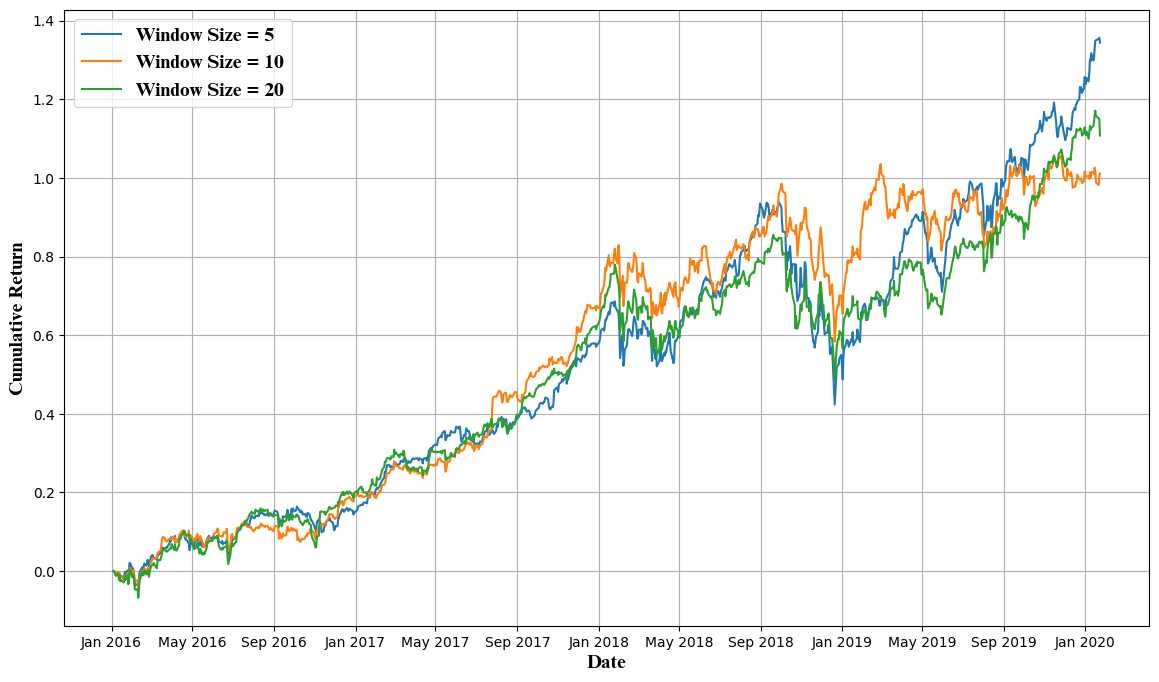

                  Cumulative Return %  Max Earning Rate %  Maximum Pullback %  \
Window Size = 5            134.399816          135.615343           26.580358   
Window Size = 10           101.089847          105.644707           20.261343   
Window Size = 20           110.764114          117.047613           19.883844   

                      APPT  Sharpe Ratio  
Window Size = 5   1.031741      1.462826  
Window Size = 10  0.823146      1.228250  
Window Size = 20  1.116210      1.302072  


In [ ]:
base_model_dir = "model"
window_sizes = [5, 10, 20]
hyperparameters = [
    {'n_steps': 128, 'batch_size': 128, 'n_epochs': 10, 'learning_rate': 3e-4, 'max_grad_norm': 0.5}
]

i = 5
for idx, params in enumerate(hyperparameters):
    print(f"Evaluating with hyperparameters set {i}")
    portfolio_values_list = []
    labels = []
    metrics_list = []
    history_dict = {}

    pdf_path = os.path.join('final_results', f"Hyperparameter_Set_{i}.pdf")
    with PdfPages(pdf_path) as pdf:
        for window_size in window_sizes:
            model_subdir = os.path.join(base_model_dir, f"set{i}_window_{window_size}_params_1")
            model_path = os.path.join(model_subdir, f"recurrent_ppo_stock_trading_model.zip")
            portfolio_values, metrics = evaluate_model(
                model_path,
                test_data,
                test_embeddings,
                test_turbulence_index,
                window_size,
                turbulence_threshold
            )
            portfolio_values_list.append(portfolio_values)
            labels.append(f"Window Size = {window_size}")
            metrics_list.append(metrics)
            history_dict[f"Window_Size_{window_size}"] = portfolio_values.values
            print(f"Metrics for window size {window_size}: {metrics}")

        # Plot combined returns and save to PDF
        plot_returns(portfolio_values_list, labels, f"Combined Returns for Hyperparameter Set {i}", font_prop, pdf)

    # Save metrics to a CSV file
    metrics_df = pd.DataFrame(metrics_list, index=labels)
    metrics_df.to_csv(os.path.join('final_results', f"Metrics_Hyperparameter_Set_{i}.csv"), index=True)

    # Save history to a numpy file
    np.save(os.path.join('final_results', f"History_Hyperparameter_Set_{i}.npy"), history_dict)

    # Display metrics in a table format for reference
    print(metrics_df)

    i += 1

Correct APPT

Evaluating with hyperparameters set 5


/usr/local/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Length of portfolio_values: 1021
Length of test_actions_np: 1021
Metrics for window size 5: {'Cumulative Return %': 131.0760731477228, 'Max Earning Rate %': 132.15392392584508, 'Maximum Pullback %': 24.441714935249895, 'APPT': 49.6690841015089, 'Sharpe Ratio': 1.4913963126296497}
Length of portfolio_values: 1021
Length of test_actions_np: 1021
Metrics for window size 10: {'Cumulative Return %': 99.63783460325499, 'Max Earning Rate %': 106.72882649736218, 'Maximum Pullback %': 20.660988636469355, 'APPT': 38.24003883771406, 'Sharpe Ratio': 1.1998841524938662}
Length of portfolio_values: 1021
Length of test_actions_np: 1021
Metrics for window size 20: {'Cumulative Return %': 106.74077564763256, 'Max Earning Rate %': 113.71992021290936, 'Maximum Pullback %': 20.17167816492792, 'APPT': 41.7110906058167, 'Sharpe Ratio': 1.2869995250476225}


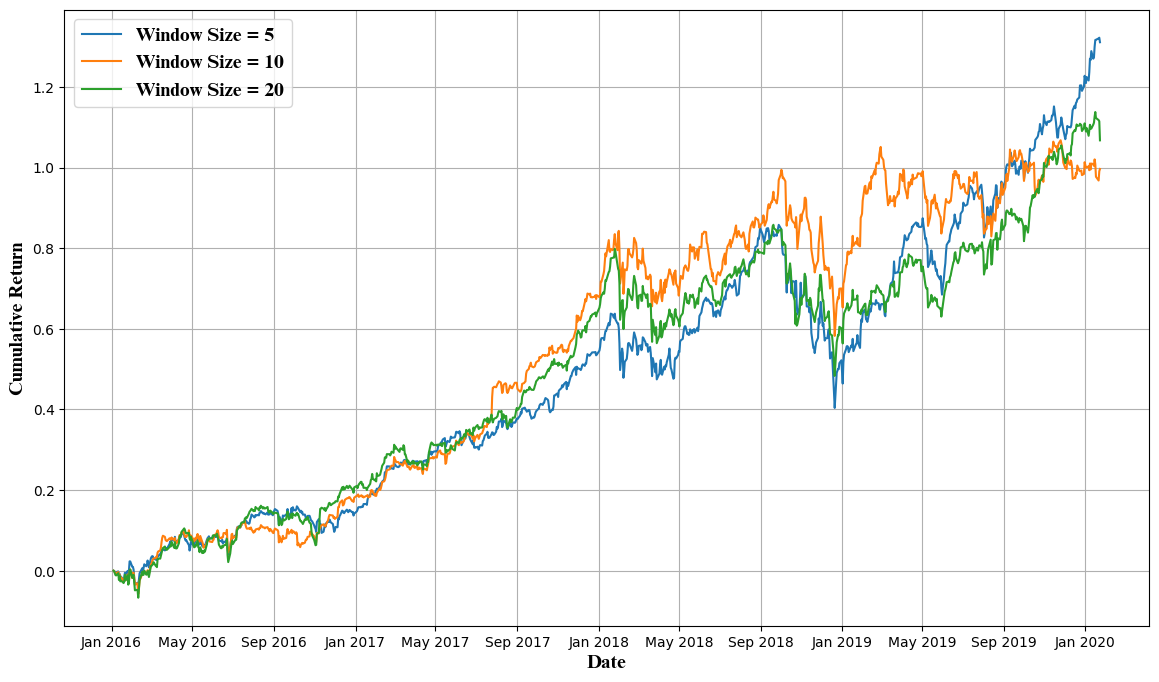

                  Cumulative Return %  Max Earning Rate %  Maximum Pullback %  \
Window Size = 5            131.076073          132.153924           24.441715   
Window Size = 10            99.637835          106.728826           20.660989   
Window Size = 20           106.740776          113.719920           20.171678   

                       APPT  Sharpe Ratio  
Window Size = 5   49.669084      1.491396  
Window Size = 10  38.240039      1.199884  
Window Size = 20  41.711091      1.287000  


In [ ]:
def calculate_cumulative_return(portfolio_values):
    if len(portfolio_values) == 0:
        return 0
    initial_value = portfolio_values.iloc[0]
    final_value = portfolio_values.iloc[-1]
    cumulative_return = (final_value - initial_value) / initial_value
    return cumulative_return

def calculate_max_earning_rate(portfolio_values, initial_cash):
    if len(portfolio_values) == 0:
        return 0
    max_earning_rate = (portfolio_values.max() - initial_cash) / initial_cash
    return max_earning_rate

def calculate_max_pullback(portfolio_values):
    if len(portfolio_values) == 0:
        return 0
    drawdowns = []
    peak = portfolio_values.iloc[0]
    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        drawdowns.append(drawdown)
    max_pullback = max(drawdowns)
    return max_pullback

def calculate_appt(portfolio_values, initial_cash, test_actions):
    if len(portfolio_values) == 0 or len(test_actions) == 0:
        return 0
    trades = np.diff(test_actions) != 0  # Identify trades
    trade_indices = np.where(trades)[0] + 1  # Indices where trades occurred

    trade_profits = []
    start_value = initial_cash
    for idx in trade_indices:
        if idx < len(portfolio_values):
            end_value = portfolio_values.iloc[idx]
            trade_profits.append(end_value - start_value)
            start_value = end_value  # Update the start value for the next trade
    appt = np.mean(trade_profits) if trade_profits else 0
    return appt

def calculate_sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    if len(returns) == 0:
        return 0
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    annualized_return = mean_return * periods_per_year
    annualized_volatility = std_return * np.sqrt(periods_per_year)
    annualized_risk_free_rate = risk_free_rate
    sharpe_ratio = (annualized_return - annualized_risk_free_rate) / annualized_volatility
    return sharpe_ratio


def evaluate_model(model_path, test_data, test_embeddings, test_turbulence_index, window_size, turbulence_threshold, initial_cash=1_000_000):
    model = RecurrentPPO.load(model_path)
    test_env = StockTradingEnv(test_data, test_embeddings, test_turbulence_index, window_size=window_size, turbulence_threshold=turbulence_threshold)
    obs, _ = test_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = test_env.step(action)
    test_total_values = test_env.get_total_values()
    test_actions = test_env.get_actions()

    if len(test_total_values) == 0:
        raise ValueError("Test environment returned no total values")

    portfolio_values = pd.Series(test_total_values, index=test_data.index[:len(test_total_values)])
    returns = portfolio_values.pct_change().dropna()
    test_actions_np = np.array(test_actions)
    number_of_trades = np.sum(test_actions_np[test_actions_np < 0] * (-100))

    print(f"Length of portfolio_values: {len(portfolio_values)}")
    print(f"Length of test_actions_np: {len(test_actions_np)}")

    metrics = {
        "Cumulative Return %": calculate_cumulative_return(portfolio_values) * 100,
        "Max Earning Rate %": calculate_max_earning_rate(portfolio_values, initial_cash) * 100,
        "Maximum Pullback %": calculate_max_pullback(portfolio_values) * 100,
        "APPT": calculate_appt(portfolio_values, initial_cash, test_actions_np),
        "Sharpe Ratio": calculate_sharpe_ratio(returns)
    }
    return portfolio_values, metrics

def plot_returns(portfolio_values_list, labels, title, font_prop, pdf):
    plt.figure(figsize=(14, 8))
    for portfolio_values, label in zip(portfolio_values_list, labels):
        plt.plot(portfolio_values.index, (portfolio_values - portfolio_values.iloc[0]) / portfolio_values.iloc[0], label=label)
    plt.xlabel('Date', fontproperties=font_prop)
    plt.ylabel('Cumulative Return', fontproperties=font_prop)
    plt.legend(prop=font_prop)
    plt.grid(True)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 5, 9]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    if pdf:
        pdf.savefig()
    plt.show()

base_model_dir = "model"
window_sizes = [5, 10, 20]
hyperparameters = [
    {'n_steps': 128, 'batch_size': 128, 'n_epochs': 10, 'learning_rate': 3e-4, 'max_grad_norm': 0.5}
]

i = 5
for idx, params in enumerate(hyperparameters):
    print(f"Evaluating with hyperparameters set {i}")
    portfolio_values_list = []
    labels = []
    metrics_list = []
    history_dict = {}

    pdf_path = os.path.join('just_testing', f"Hyperparameter_Set_{i}.pdf")
    with PdfPages(pdf_path) as pdf:
        for window_size in window_sizes:
            model_subdir = os.path.join(base_model_dir, f"set{i}_window_{window_size}_params_1")
            model_path = os.path.join(model_subdir, f"recurrent_ppo_stock_trading_model.zip")
            portfolio_values, metrics = evaluate_model(
                model_path,
                test_data,
                test_embeddings,
                test_turbulence_index,
                window_size,
                turbulence_threshold
            )
            portfolio_values_list.append(portfolio_values)
            labels.append(f"Window Size = {window_size}")
            metrics_list.append(metrics)
            history_dict[f"Window_Size_{window_size}"] = portfolio_values.values
            print(f"Metrics for window size {window_size}: {metrics}")

        plot_returns(portfolio_values_list, labels, f"Combined Returns for Hyperparameter Set {i}", font_prop, pdf)

    metrics_df = pd.DataFrame(metrics_list, index=labels)
    metrics_df.to_csv(os.path.join('just_testing', f"Metrics_Hyperparameter_Set_{i}.csv"), index=True)
    np.save(os.path.join('just_testing', f"History_Hyperparameter_Set_{i}.npy"), history_dict)
    print(metrics_df)

    i += 1

## compare

In [ ]:
ls

 aligned_test_data.pkl          model/
 aligned_test_embeddings.pkl    news_data_with_tensor_embeddings_all.pkl
 aligned_train_data.pkl         results/
 aligned_train_embeddings.pkl   test_data_with_indicators.pkl
 Compare/                       test_embeddings.csv
 daily_embeddings.csv           test_embeddings.pkl
 daily_embeddings_df.csv       'times new roman bold.ttf'
 daily_embeddings_df.pkl        train_data_with_indicators.pkl
 daily_embeddings.pkl           train_embeddings.csv
 filtered_news_data.csv         train_embeddings.pkl
 final_results/                 yetanother/
 just_testing/


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Load the history data
history_data = np.load('final_results/History_Hyperparameter_Set_5.npy', allow_pickle=True).item()

# Inspect the keys to understand the structure
print("Available keys in history_data:", history_data.keys())

Available keys in history_data: dict_keys(['Window_Size_5', 'Window_Size_10', 'Window_Size_20'])


In [ ]:
# Inspect the data for the window size 5
window_5_data = history_data.get('Window_Size_5', None)
if window_5_data is not None:
    print("Window Size 5 Data Sample:", window_5_data[:10])  # Print the first 10 values
else:
    print("No data found for Window Size 5")

Window Size 5 Data Sample: [999828.92146765 998835.85879445 995859.79987143 994428.43293138
 995543.35766747 996983.50607904 990080.69151241 991751.62831909
 986620.37005999 988712.05491246]


In [ ]:
# Load the PPO data
array_ppo = np.load('Compare/arrayPPO.npy')

In [ ]:
array_ppo

array([-1.62580216e-04, -1.68491509e-03, -5.36233691e-03, ...,
        3.30748842e-01,  3.30908800e-01,  3.06385445e-01])

In [ ]:
# Inspect the data for the window size 5
window_5_data = history_data.get('Window_Size_5', None)
if window_5_data is not None:
    print("Window Size 5 Data Sample:", window_5_data[:10])  # Print the first 10 values
else:
    print("No data found for Window Size 5")

Window Size 5 Data Sample: [999828.92146765 998835.85879445 995859.79987143 994428.43293138
 995543.35766747 996983.50607904 990080.69151241 991751.62831909
 986620.37005999 988712.05491246]


In [ ]:
ls

 aligned_test_data.pkl          just_testing/
 aligned_test_embeddings.pkl    model/
 aligned_train_data.pkl         news_data_with_tensor_embeddings_all.pkl
 aligned_train_embeddings.pkl   results/
 Compare/                       test_data_with_indicators.pkl
 cumulative_returns_plot.pdf    test_embeddings.csv
 daily_embeddings.csv           test_embeddings.pkl
 daily_embeddings_df.csv       'times new roman bold.ttf'
 daily_embeddings_df.pkl        train_data_with_indicators.pkl
 daily_embeddings.pkl           train_embeddings.csv
 filtered_news_data.csv         train_embeddings.pkl
 final_results/                 yetanother/


In [ ]:
cd /content/drive/MyDrive/DRL/project/extract/new_article

/content/drive/MyDrive/DRL/project/extract/new_article


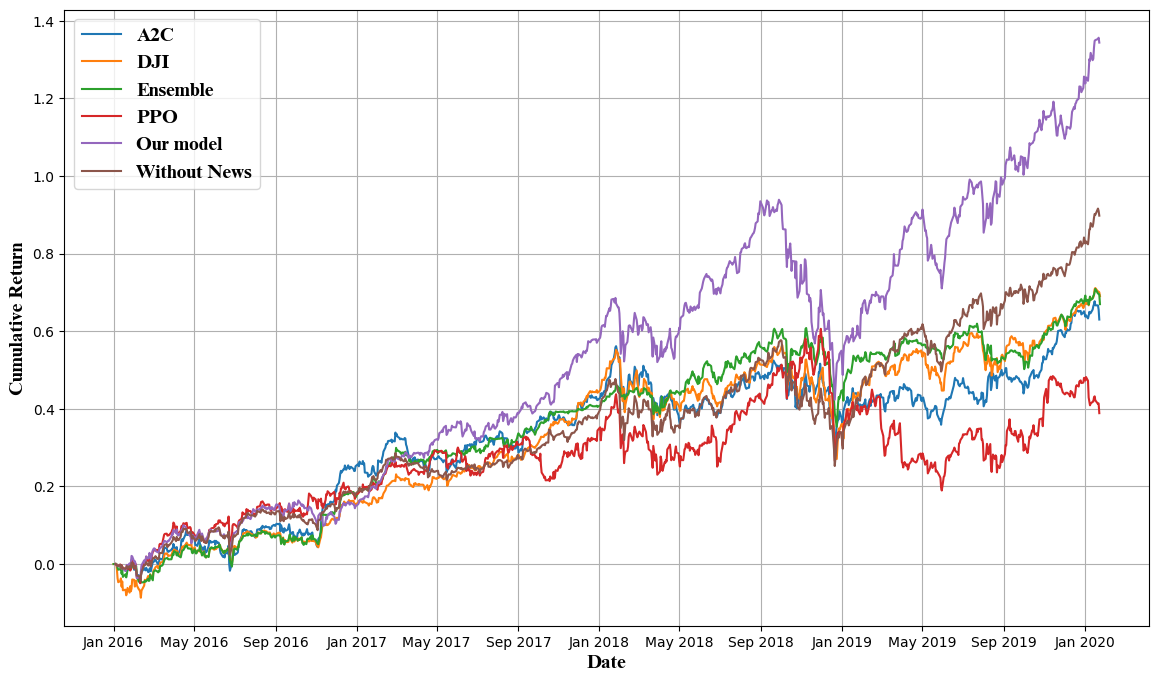

In [ ]:
# Load the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages

# Load the data
array_a2c = np.load('Compare/arrayA2C(1).npy')
array_index = np.load('Compare/arrayindex.npy')
array_ppo = np.load('Compare/arrayPPO(3).npy')

# Load the history data
history_data = np.load('final_results/History_Hyperparameter_Set_5.npy', allow_pickle=True).item()
without_news_data = np.load('Compare/without_news.npy', allow_pickle=True).item()  # New data loading

# Extract data for window size 5
window_5_data = history_data.get('Window_Size_5', None)
if window_5_data is None:
    raise ValueError("No data found for Window Size 5")

without_news_data_window_5 = without_news_data.get('Window_Size_5', None)  # Extract window size 5 data for without_news
if without_news_data_window_5 is None:
    raise ValueError("No data found for Window Size 5 in without_news")

# Convert array_index to datetime if it is not already
dates = pd.to_datetime(array_index)

# Ensure dates array matches the length of each data array
dates_a2c = dates[:len(array_a2c)]
dates_ppo = dates[:len(array_ppo)]

# Define the cutoff date
cutoff_date = '2020-01-25'

# Filter the data up to the cutoff date
mask_a2c = dates_a2c <= pd.to_datetime(cutoff_date)
filtered_dates_a2c = dates_a2c[mask_a2c]
filtered_returns_a2c = array_a2c[mask_a2c]

mask_ppo = dates_ppo <= pd.to_datetime(cutoff_date)
filtered_dates_ppo = dates_ppo[mask_ppo]
filtered_returns_ppo = array_ppo[mask_ppo]

# Calculate cumulative returns for Window Size 5
initial_value_window_5 = window_5_data[0]
cumulative_returns_window_5 = (window_5_data - initial_value_window_5) / initial_value_window_5
filtered_dates_window_5 = dates_a2c[mask_a2c][:len(cumulative_returns_window_5)]

# Calculate cumulative returns for 'without_news' Window Size 5
initial_value_without_news = without_news_data_window_5[0]
cumulative_returns_without_news = (without_news_data_window_5 - initial_value_without_news) / initial_value_without_news
filtered_dates_without_news = dates_a2c[mask_a2c][:len(cumulative_returns_without_news)]

# Create Pandas Series for the filtered returns
returns_a2c = pd.Series(filtered_returns_a2c, index=filtered_dates_a2c)
returns_ppo = pd.Series(filtered_returns_ppo, index=filtered_dates_ppo)
returns_window_5 = pd.Series(cumulative_returns_window_5, index=filtered_dates_window_5)
returns_without_news = pd.Series(cumulative_returns_without_news, index=filtered_dates_without_news)  # New series for without_news

# Load and handle the new DJI and Ensemble data from results.csv
file_path = 'Compare/results.csv'
data = pd.read_csv(file_path)

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Set the 'date' column as the index
data.set_index('date', inplace=True)

# Define the specific dates to fill with zero (first 4 days of 2016)
specific_dates_to_fill = pd.date_range(start='2016-01-01', end='2016-01-04', freq='B')

# Create a DataFrame for these specific dates filled with zeros
missing_data = pd.DataFrame(0, index=specific_dates_to_fill, columns=data.columns)

# Append this missing data to the original data and sort by date
data = pd.concat([missing_data, data]).sort_index()

# Filter the data to ensure it only goes up to January 25th, 2020
end_date = pd.to_datetime('2020-01-25')
data = data[data.index <= end_date]

# Extract the filtered returns from the new data
returns_dji = data['dji']
returns_ensemble = data['ensemble']

# Plotting
font_path = 'times new roman bold.ttf'
font_prop = FontProperties(fname=font_path, size=14)

# Create a PdfPages object
with PdfPages('cumulative_returns_plot_combined.pdf') as pdf:
    plt.figure(figsize=(14, 8))
    plt.plot(returns_a2c.index, returns_a2c, label='A2C')
    plt.plot(returns_dji.index, returns_dji, label='DJI')
    plt.plot(returns_ensemble.index, returns_ensemble, label='Ensemble')
    plt.plot(returns_ppo.index, returns_ppo, label='PPO')
    plt.plot(returns_window_5.index, returns_window_5, label='Our model')
    plt.plot(returns_without_news.index, returns_without_news, label='Without News')  # New plot for without_news

    plt.xlabel('Date', fontproperties=font_prop)
    plt.ylabel('Cumulative Return', fontproperties=font_prop)
    plt.legend(prop=font_prop)
    plt.grid(True)

    # Format the x-axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 5, 9]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    # Save the plot to the PDF
    pdf.savefig()
    plt.show()


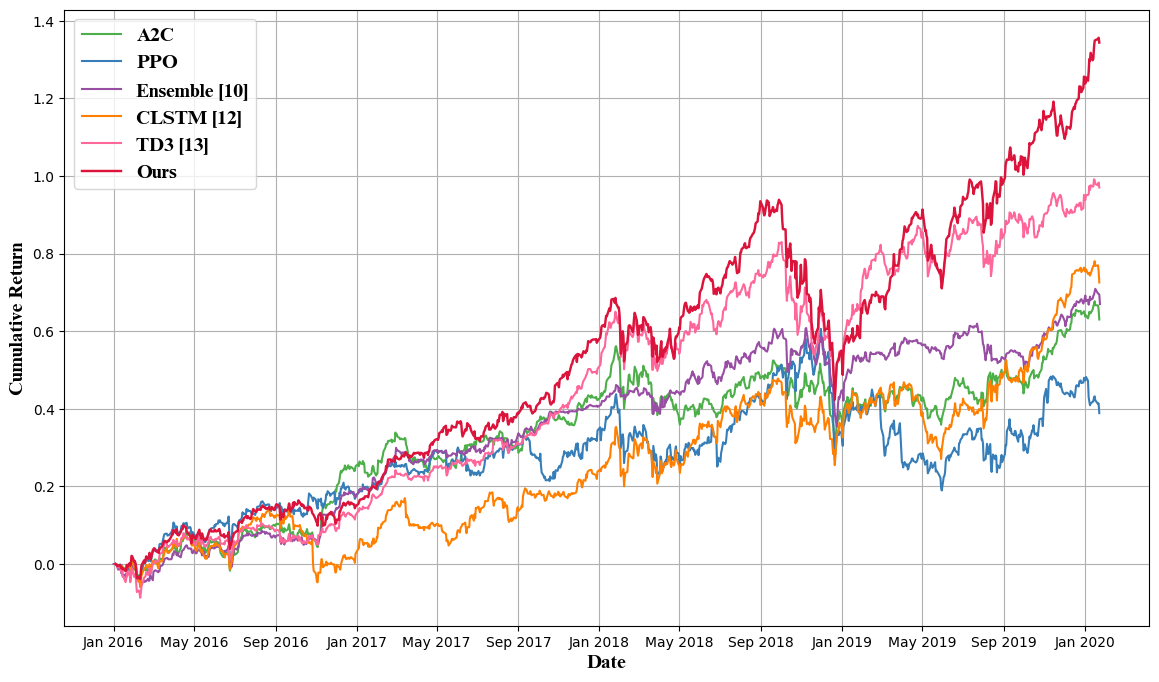

In [ ]:
# Load the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages

# Load the data
array_a2c = np.load('Compare/arrayA2C(1).npy')
array_index = np.load('Compare/arrayindex.npy')
array_ppo = np.load('Compare/arrayPPO(3).npy')

# Load the history data and portfolios for CLSTM and TD3
history_data = np.load('final_results/History_Hyperparameter_Set_5.npy', allow_pickle=True).item()
without_news_data = np.load('Compare/without_news.npy', allow_pickle=True).item()  # New data loading
clstm_portfolio = np.load('Compare/CLSTM Step 40,000_portfolio.npy', allow_pickle=True)
td3_portfolio = np.load('Compare/TD3_Step_100,000_portfolio.npy', allow_pickle=True)

# Extract data for window size 5
window_5_data = history_data.get('Window_Size_5', None)
if window_5_data is None:
    raise ValueError("No data found for Window Size 5")

without_news_data_window_5 = without_news_data.get('Window_Size_5', None)  # Extract window size 5 data for without_news
if without_news_data_window_5 is None:
    raise ValueError("No data found for Window Size 5 in without_news")

# Convert array_index to datetime if it is not already
dates = pd.to_datetime(array_index)

# Ensure dates array matches the length of each data array
dates_a2c = dates[:len(array_a2c)]
dates_ppo = dates[:len(array_ppo)]

# Define the cutoff date
cutoff_date = '2020-01-25'

# Filter the data up to the cutoff date
mask_a2c = dates_a2c <= pd.to_datetime(cutoff_date)
filtered_dates_a2c = dates_a2c[mask_a2c]
filtered_returns_a2c = array_a2c[mask_a2c]

mask_ppo = dates_ppo <= pd.to_datetime(cutoff_date)
filtered_dates_ppo = dates_ppo[mask_ppo]
filtered_returns_ppo = array_ppo[mask_ppo]

# Calculate cumulative returns for Window Size 5
initial_value_window_5 = window_5_data[0]
cumulative_returns_window_5 = (window_5_data - initial_value_window_5) / initial_value_window_5
filtered_dates_window_5 = dates_a2c[mask_a2c][:len(cumulative_returns_window_5)]

# Calculate cumulative returns for 'without_news' Window Size 5
initial_value_without_news = without_news_data_window_5[0]
cumulative_returns_without_news = (without_news_data_window_5 - initial_value_without_news) / initial_value_without_news
filtered_dates_without_news = dates_a2c[mask_a2c][:len(cumulative_returns_without_news)]

# Calculate cumulative returns for CLSTM
initial_value_clstm = clstm_portfolio[0]
cumulative_returns_clstm = (clstm_portfolio - initial_value_clstm) / initial_value_clstm
filtered_dates_clstm = dates_a2c[mask_a2c][:len(cumulative_returns_clstm)]

# Calculate cumulative returns for TD3
initial_value_td3 = td3_portfolio[0]
cumulative_returns_td3 = (td3_portfolio - initial_value_td3) / initial_value_td3
filtered_dates_td3 = dates_a2c[mask_a2c][:len(cumulative_returns_td3)]

# Create Pandas Series for the filtered returns
returns_a2c = pd.Series(filtered_returns_a2c, index=filtered_dates_a2c)
returns_ppo = pd.Series(filtered_returns_ppo, index=filtered_dates_ppo)
returns_window_5 = pd.Series(cumulative_returns_window_5, index=filtered_dates_window_5)
returns_without_news = pd.Series(cumulative_returns_without_news, index=filtered_dates_without_news)
returns_clstm = pd.Series(cumulative_returns_clstm, index=filtered_dates_clstm)
returns_td3 = pd.Series(cumulative_returns_td3, index=filtered_dates_td3)

# Load and handle the new DJI and Ensemble data from results.csv
file_path = 'Compare/results.csv'
data = pd.read_csv(file_path)

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Set the 'date' column as the index
data.set_index('date', inplace=True)

# Define the specific dates to fill with zero (first 4 days of 2016)
specific_dates_to_fill = pd.date_range(start='2016-01-01', end='2016-01-04', freq='B')

# Create a DataFrame for these specific dates filled with zeros
missing_data = pd.DataFrame(0, index=specific_dates_to_fill, columns=data.columns)

# Append this missing data to the original data and sort by date
data = pd.concat([missing_data, data]).sort_index()

# Filter the data to ensure it only goes up to January 25th, 2020
end_date = pd.to_datetime('2020-01-25')
data = data[data.index <= end_date]

# Extract the filtered returns from the new data
returns_dji = data['dji']
returns_ensemble = data['ensemble']

# D# Define a list of colors using the Set1 colormap for distinct colors
colors = list(iter([plt.cm.Set1(i) for i in range(7)]))  # You can change 'Set1' to any other colormap from the link

# Plotting
font_path = 'times new roman bold.ttf'
font_prop = FontProperties(fname=font_path, size=14)

# Create a PdfPages object
with PdfPages('cumulative_returns_plot_combined.pdf') as pdf:
    plt.figure(figsize=(14, 8))

    # Plot the cumulative returns for each model using the colormap for colors
    plt.plot(returns_a2c.index, returns_a2c, label='A2C', color=colors[2])
    plt.plot(returns_ppo.index, returns_ppo, label='PPO', color=colors[1])
    # plt.plot(returns_dji.index, returns_dji, label='DJIA', color=colors[2])
    plt.plot(returns_ensemble.index, returns_ensemble, label='Ensemble [10]', color=colors[3])
    plt.plot(returns_clstm.index, returns_clstm, label='CLSTM [12]', color=colors[4])
    plt.plot(returns_td3.index, returns_td3, label='TD3 [13]', color=(1, 0.4, 0.6))

    # Highlighting your model with a strong crimson color and thicker line
    plt.plot(returns_window_5.index, returns_window_5, label='Ours', color='crimson', linewidth=1.75)

    # Set the labels, legend, and grid
    plt.xlabel('Date', fontproperties=font_prop)
    plt.ylabel('Cumulative Return', fontproperties=font_prop)
    plt.legend(prop=font_prop)
    plt.grid(True)

    # Format the x-axis with date labels
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 5, 9]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    # Save the plot to the PDF file
    pdf.savefig()
    plt.show()